Make simulate data faster using just a unique estimation for each run, and not estimate each time just a single number.

# Set Up

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

Cloning into 'thesis'...
remote: Enumerating objects: 1222, done.
remote: Counting objects: 100% (471/471), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 1222 (delta 324), reused 331 (delta 224), pack-reused 751
Receiving objects: 100% (1222/1222), 61.48 MiB | 11.19 MiB/s, done.
Resolving deltas: 100% (767/767), done.
Updating files: 100% (64/64), done.
Mounted at /content/drive


In [2]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_labeled_data_unified_processed.csv')
fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_snews_processed.csv')
vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv')
yt=pd.read_csv('/content/drive/MyDrive/thesis/data/youtube/processed_sample.csv')

fbb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_brexit_all_comments_scored_processed.csv')

fbv=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_vaccines_all_comments_scored_processed.csv')


In [3]:
fb = fb[fb['temporal_distance_birth_h'] < 100].copy()
fb['temporal_distance_birth_base_100h'] = fb['temporal_distance_birth_h'] / 100
fb['IAT_base_100h']=fb['IAT_user_thread']/(60*60*100)

fbb = fbb[fbb['temporal_distance_birth_h'] < 100].copy()
fbb['temporal_distance_birth_base_100h'] = fbb['temporal_distance_birth_h'] / 100
fbb['user_id']=fbb['from_id']
fbb['IAT_base_100h']=fbb['IAT_user_thread']/(60*60*100)

fbv = fbv[fbv['temporal_distance_birth_h'] < 100].copy()
fbv['temporal_distance_birth_base_100h'] = fbv['temporal_distance_birth_h'] / 100
fbv['user_id']=fbv['from_id']
fbv['IAT_base_100h']=fbv['IAT_user_thread']/(60*60*100)

rd = rd[rd['temporal_distance_birth_h'] < 100].copy()
rd['IAT_base_100h']=rd['IAT_user_thread']/(60*60*100)
rd['comment_id']=rd['comment_code']
rd['temporal_distance_birth_base_100h'] = rd['temporal_distance_birth_h'] / 100

vo = vo[vo['temporal_distance_birth_h'] < 100].copy()
vo['IAT_base_100h']=vo['IAT_user_thread']/(60*60*100)
vo['temporal_distance_birth_base_100h'] = vo['temporal_distance_birth_h'] / 100
vo['post_id'] = vo['root_submission']
vo['user_id']=vo['user']

yt = yt[yt['temporal_distance_birth_h'] < 100].copy()
yt['IAT_base_100h']=yt['IAT_user_thread']/(60*60*100)
yt['temporal_distance_birth_base_100h'] = yt['temporal_distance_birth_h'] / 100
yt['user_id']=yt['user']



### Density of the  conversation

<ipython-input-4-bd9795dbdfbe>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='source', y='IAT_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'red', 'blue'])


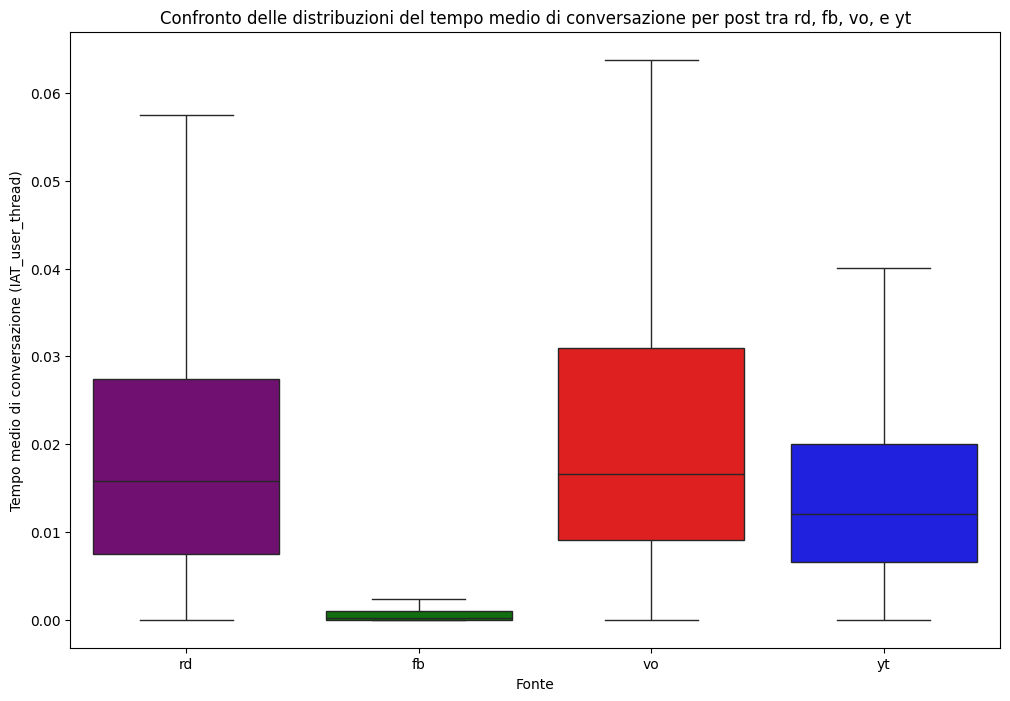

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_rd = rd.groupby(['user_id', 'post_id'])['IAT_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_rd = time_of_conversation_rd.groupby('post_id')['IAT_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in fb
time_of_conversation_fb = fb.groupby(['user_id', 'post_id'])['IAT_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in fb
mean_time_of_conversation_fb = time_of_conversation_fb.groupby('post_id')['IAT_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in vo
time_of_conversation_vo = vo.groupby(['user_id', 'post_id'])['IAT_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in vo
mean_time_of_conversation_vo = time_of_conversation_vo.groupby('post_id')['IAT_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in yt
time_of_conversation_yt = yt.groupby(['user_id', 'post_id'])['IAT_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in yt
mean_time_of_conversation_yt = time_of_conversation_yt.groupby('post_id')['IAT_base_100h'].mean().reset_index()

# Unire i dati per fare il confronto
mean_time_of_conversation_rd['source'] = 'rd'
mean_time_of_conversation_fb['source'] = 'fb'
mean_time_of_conversation_vo['source'] = 'vo'
mean_time_of_conversation_yt['source'] = 'yt'

combined_data = pd.concat([
    mean_time_of_conversation_rd,
    mean_time_of_conversation_fb,
    mean_time_of_conversation_vo,
    mean_time_of_conversation_yt
])

# Creare i boxplot per confrontare le distribuzioni
plt.figure(figsize=(12, 8))
sns.boxplot(x='source', y='IAT_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'red', 'blue'])
plt.title('Confronto delle distribuzioni del tempo medio di conversazione per post tra rd, fb, vo, e yt')
plt.xlabel('Fonte')
plt.ylabel('Tempo medio di conversazione (IAT_user_thread)')
plt.show()


In [ ]:
time_of_conversation_yt['IAT_base_100h'].mean()
time_of_conversation_vo['IAT_base_100h'].mean()
time_of_conversation_rd['IAT_base_100h'].mean()
time_of_conversation_fb['IAT_base_100h'].mean()

0.0010798984700745435

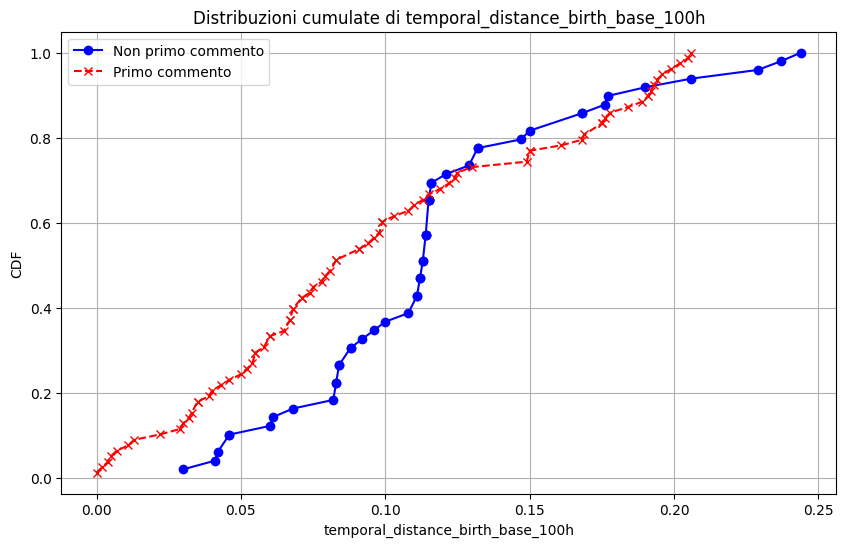

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo che 'rd' sia il DataFrame contenente i dati
# Sostituisci questa linea con il caricamento reale dei tuoi dati, ad esempio:
# rd = pd.read_csv('tuo_file.csv')

# Filtra il thread con 'post_id' specifico
thread = rd[rd['post_id'] == 'zi0360']

# Filtra per escludere il primo commento di ciascun utente nel thread
cc = thread[thread['sequential_number_of_comment_by_user_in_thread'] != 1]['temporal_distance_birth_base_100h']
fc = thread[thread['sequential_number_of_comment_by_user_in_thread'] == 1]['temporal_distance_birth_base_100h']


# Calcola le distribuzioni cumulate
cc_sorted = cc.sort_values().reset_index(drop=True)
cc_cdf = cc_sorted.rank(method='max') / len(cc_sorted)

fc_sorted = fc.sort_values().reset_index(drop=True)
fc_cdf = fc_sorted.rank(method='max') / len(fc_sorted)

# Plot delle distribuzioni cumulate
plt.figure(figsize=(10, 6))
plt.plot(cc_sorted, cc_cdf, label='Non primo commento', marker='o', linestyle='-', color='b')
plt.plot(fc_sorted, fc_cdf, label='Primo commento', marker='x', linestyle='--', color='r')
plt.title('Distribuzioni cumulate di temporal_distance_birth_base_100h')
plt.xlabel('temporal_distance_birth_base_100h')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

### Draw lifetime of the conversation

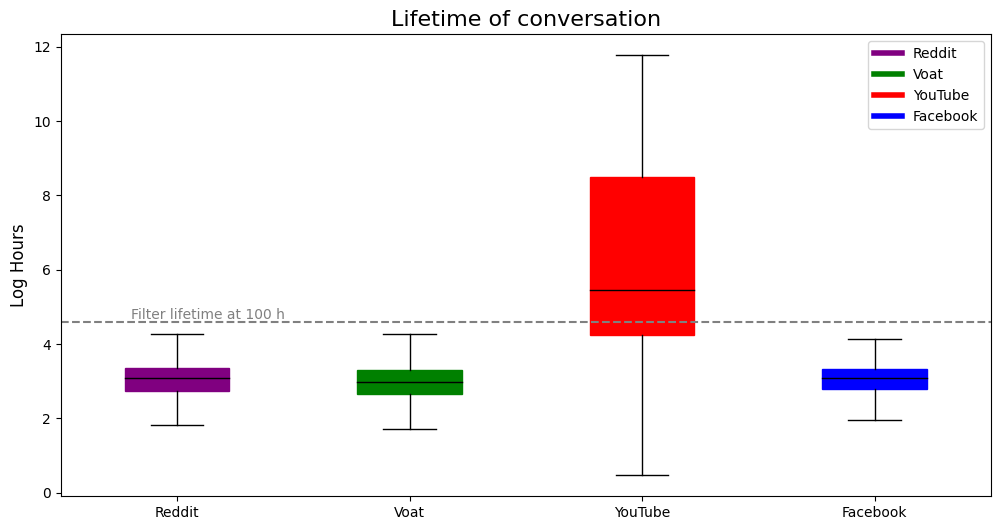

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dati di esempio per dimostrazione
# np.random.seed(0)
# fb = pd.DataFrame({'post_id': np.random.randint(0, 100, 1000), 'temporal_distance_birth_h': np.random.exponential(scale=100, size=1000)})
# rd = pd.DataFrame({'post_id': np.random.randint(0, 100, 1000), 'temporal_distance_birth_h': np.random.exponential(scale=100, size=1000)})
# yt = pd.DataFrame({'post_id': np.random.randint(0, 100, 1000), 'temporal_distance_birth_h': np.random.exponential(scale=100, size=1000)})
# vo = pd.DataFrame({'post_id': np.random.randint(0, 100, 1000), 'temporal_distance_birth_h': np.random.exponential(scale=100, size=1000)})

# Calcolare i dati per i boxplot
fb_data = np.log(fb.groupby(['post_id'])['temporal_distance_birth_h'].quantile(0.95).reset_index()['temporal_distance_birth_h'])
rd_data = np.log(rd.groupby(['post_id'])['temporal_distance_birth_h'].quantile(0.95).reset_index()['temporal_distance_birth_h'])
yt_data = np.log(yt.groupby(['post_id'])['temporal_distance_birth_h'].quantile(0.95).reset_index()['temporal_distance_birth_h'])
vo_data = np.log(vo.groupby(['post_id'])['temporal_distance_birth_h'].quantile(0.95).reset_index()['temporal_distance_birth_h'])

# Creare una figura e un unico subplot
plt.figure(figsize=(12, 6))
plt.title('Lifetime of conversation', fontsize=16)

# Creare i boxplot
colors = [ 'purple',  'green','red','blue']

box = plt.boxplot([ rd_data, vo_data,yt_data,fb_data], showfliers=False, patch_artist=True,
                  medianprops=dict(color='black'))

# Assegnare colori specifici ai boxplot
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)


# Aggiungere una legenda
plt.legend([plt.Line2D([0], [0], color=color, lw=4) for color in colors],
           [ 'Reddit',  'Voat','YouTube','Facebook'], loc='upper right')

# Etichette degli assi
plt.xticks([1, 2, 3, 4], [ 'Reddit',  'Voat','YouTube','Facebook'])
plt.ylabel('Log Hours', fontsize=12)

# Linea di riferimento
plt.axhline(y=np.log(100), color='gray', linestyle='--')
plt.text(0.8, np.log(100), 'Filter lifetime at 100 h', color='gray', fontsize=10, verticalalignment='bottom')

# Mostrare il grafico
plt.show()
# Mostrare il grafico
plt.show()


### Draw Number of users

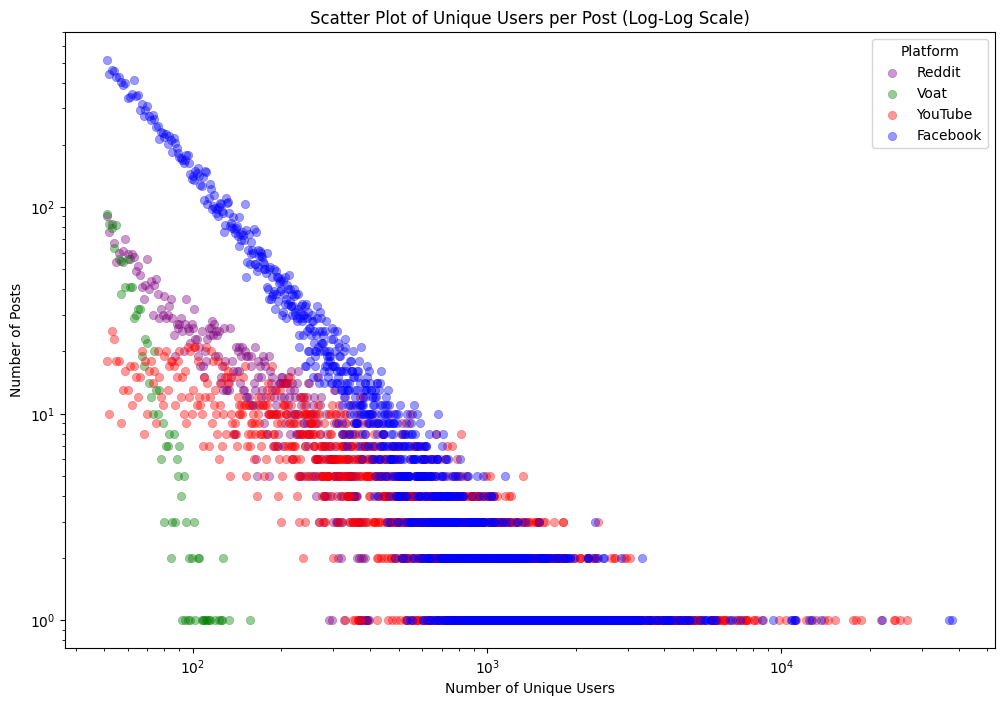

In [ ]:
# Group by 'post_id' and count unique 'user_id' for each platform
users_fb = fb.groupby('post_id')['user_id'].nunique().reset_index()
users_fbb = fbb.groupby('post_id')['user_id'].nunique().reset_index()
users_fbv = fbv.groupby('post_id')['user_id'].nunique().reset_index()
users_rd = rd.groupby('post_id')['user_id'].nunique().reset_index()
users_yt = yt.groupby('post_id')['user_id'].nunique().reset_index()
users_vo = vo.groupby('post_id')['user_id'].nunique().reset_index()

# Rename columns
users_fb.columns = ['post_id', 'user_count']
users_fbv.columns = ['post_id', 'user_count']
users_fbb.columns = ['post_id', 'user_count']
users_rd.columns = ['post_id', 'user_count']
users_yt.columns = ['post_id', 'user_count']
users_vo.columns = ['post_id', 'user_count']

# Filter to include only posts with more than 50 unique users
users_fb = users_fb[users_fb['user_count'] > 50]
users_fbv = users_fbv[users_fbv['user_count'] > 50]
users_fbb = users_fbb[users_fbb['user_count'] > 50]
users_rd = users_rd[users_rd['user_count'] > 50]
users_yt = users_yt[users_yt['user_count'] > 50]
users_vo = users_vo[users_vo['user_count'] > 50]
users_fb= pd.concat([users_fb, users_fbb, users_fbv])

# Count the number of posts with a specific number of unique users
post_count_fb = users_fb.groupby('user_count').size().reset_index(name='post_count')
post_count_rd = users_rd.groupby('user_count').size().reset_index(name='post_count')
post_count_yt = users_yt.groupby('user_count').size().reset_index(name='post_count')
post_count_vo = users_vo.groupby('user_count').size().reset_index(name='post_count')

observed_fb = users_fb['user_count']
observed_rd= users_rd['user_count']
observed_yt= users_yt['user_count']
observed_vo= users_vo['user_count']

# Create the scatter plot with log-log scale
plt.figure(figsize=(12, 8))
# Scatter plot for the Reddit data
sns.scatterplot(data=post_count_rd, x='user_count', y='post_count', alpha=0.4, label='Reddit', color='purple', edgecolor=None)

# Scatter plot for the Other data
sns.scatterplot(data=post_count_vo, x='user_count', y='post_count', alpha=0.4, label='Voat', color='green', edgecolor=None)

# Scatter plot for the YouTube data
sns.scatterplot(data=post_count_yt, x='user_count', y='post_count', alpha=0.4, label='YouTube', color='red', edgecolor=None)

# Scatter plot for the Facebook data
sns.scatterplot(data=post_count_fb, x='user_count', y='post_count', alpha=0.4, label='Facebook', color='blue', edgecolor=None)

# Set the axes to log scale
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of Unique Users per Post (Log-Log Scale)')
plt.xlabel('Number of Unique Users')
plt.ylabel('Number of Posts')

# Remove the grid
plt.grid(False)

# Add the legend
plt.legend(title='Platform')
plt.show()

# Analysis

### Evaluate toxicity

In [ ]:
fb['is_toxic']=fb['toxicity_score']>0.6

share_toxic_comments=fb.groupby(['post_id'])['is_toxic'].mean().reset_index()

threads_with_toxicity=share_toxic_comments[share_toxic_comments['is_toxic']>=share_toxic_comments['is_toxic'].quantile(0.80)]['post_id']
threads_wo_toxicity=share_toxic_comments[share_toxic_comments['is_toxic']<=share_toxic_comments['is_toxic'].quantile(0.20)]['post_id']

In [ ]:
fbt=fb[fb['post_id'].isin(threads_with_toxicity)]
fbn=fb[fb['post_id'].isin(threads_wo_toxicity)]

In [ ]:
time_intervals = np.arange(0, 1.05, 0.05)  # Utilizzo di np.arange per intervalli decimali


fbt_ECDF = calculate_ECDF(fbt, time_intervals)
fbt_ECDF['Platform']='Facebook - Toxic'
fbn_ECDF = calculate_ECDF(fbn, time_intervals)
fbn_ECDF['Platform']='Facebook - Normal'


combined_results = pd.concat([fbt_ECDF, fbn_ECDF], ignore_index=True)



Processing DataFrame: 100%|██████████| 4281/4281 [01:47<00:00, 39.78it/s]


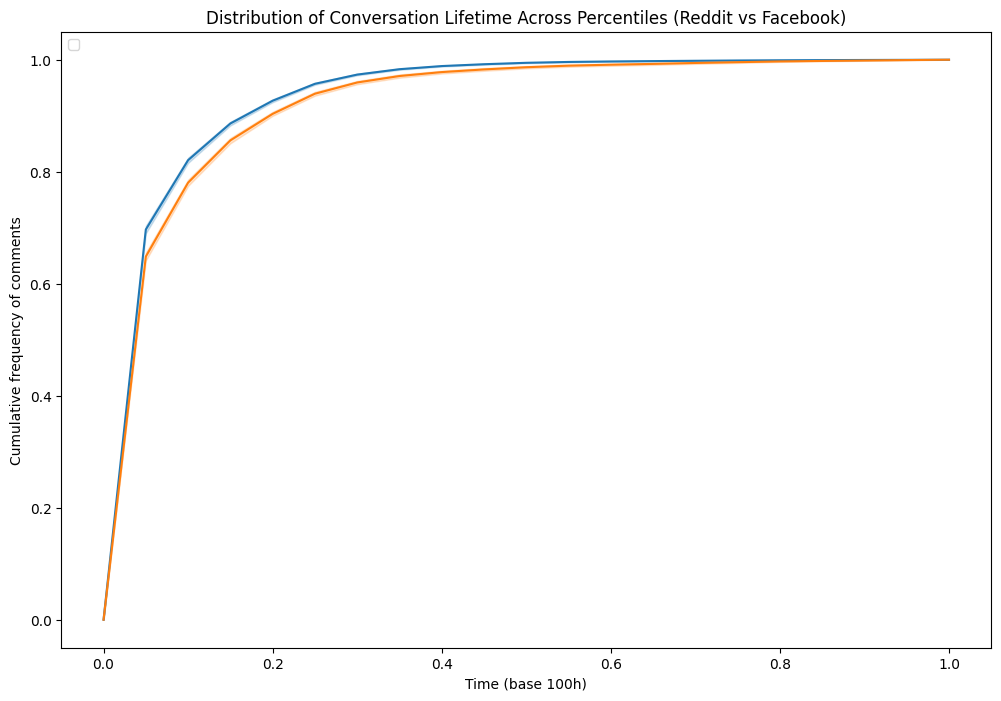

In [ ]:
df = combined_results
plt.figure(figsize=(12, 8))


line1 = sns.lineplot(data=fbt_ECDF, x='Time Grid Value', y='Share', errorbar=('ci', 99))
line2 = sns.lineplot(data=fbn_ECDF, x='Time Grid Value', y='Share', errorbar=('ci', 99))


plt.title('Distribution of Conversation Lifetime Across Percentiles (Reddit vs Facebook)')
plt.ylabel('Cumulative frequency of comments')
plt.xlabel('Time (base 100h)')
plt.grid(False)
plt.legend(loc='upper left')
plt.show()

### Starting Point - Platform Motion

In [ ]:
time_intervals = np.arange(0, 1.05, 0.02)  # Utilizzo di np.arange per intervalli decimali


fb_ECDF = calculate_ECDF(fb, time_intervals)
fb_ECDF['Platform']='Facebook'
rd_ECDF = calculate_ECDF(rd, time_intervals)
rd_ECDF['Platform']='Reddit'

vo_ECDF = calculate_ECDF(vo, time_intervals)
vo_ECDF['Platform']='Voat'

yt_ECDF = calculate_ECDF(yt, time_intervals)
yt_ECDF['Platform']='YouTube'

combined_results = pd.concat([rd_ECDF,vo_ECDF,yt_ECDF,fb_ECDF], ignore_index=True)



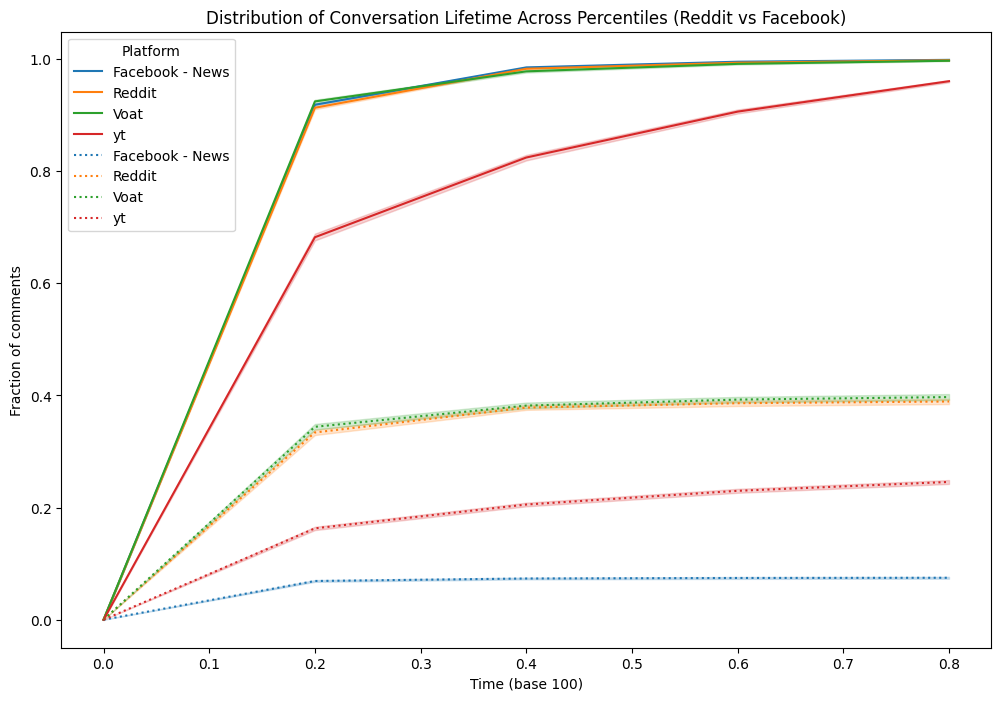

In [ ]:
df=combined_results
plot_ECDF(df,level=99)

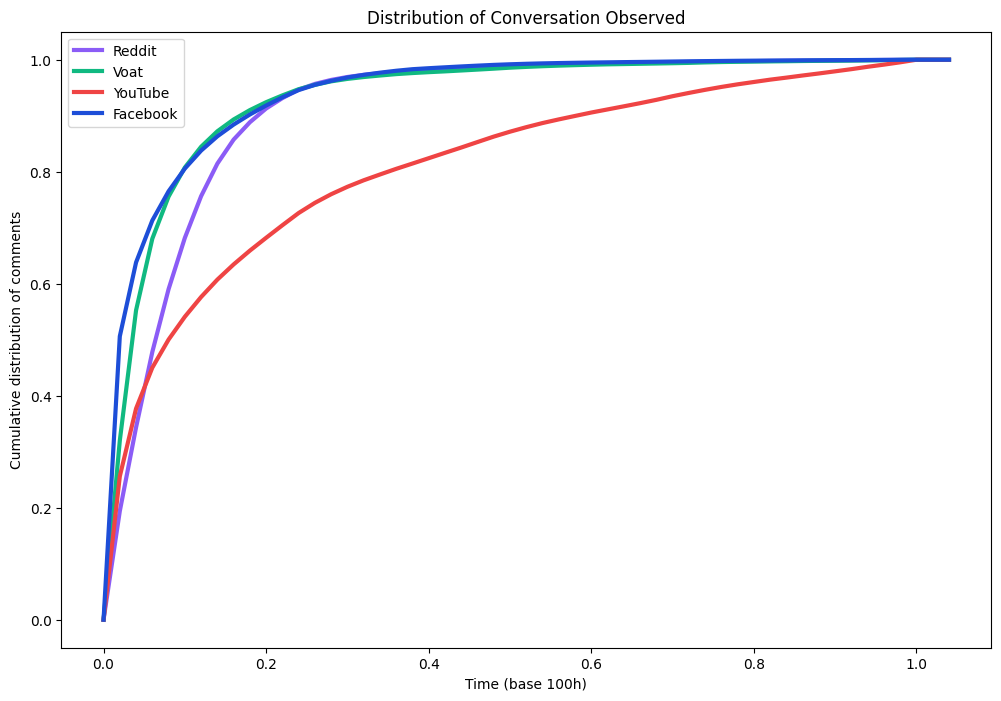

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
custom_palette = {
    'Facebook': '#1d4ed8',  # blue
    'Reddit': '#8b5cf6',    # purple
    'YouTube': '#ef4444',   # red
    'Voat': '#10b981'       # green
}

# Assuming df is your DataFrame
plt.figure(figsize=(12, 8))

# Create the line plot with the custom color palette
line1 = sns.lineplot(
    data=combined_results,
    x='Time Grid Value',
    y='Share',
    hue='Platform',
    palette=custom_palette,
    errorbar=('ci', 0.99999),
    linewidth=3  # Adjust the linewidth as needed
)

handles1, labels1 = line1.get_legend_handles_labels()

handles, labels = [], []
for handle, label in zip(handles1, labels1):
    if label not in labels:
        handles.append(handle)
        labels.append(label)

plt.title('Distribution of Conversation Observed')
plt.ylabel('Cumulative distribution of comments')
plt.xlabel('Time (base 100h)')
plt.grid(False)
plt.legend(handles=handles, labels=labels, title='')
plt.show()


## Parameter's Choice

### Number of Users

In [ ]:
users_fb=fb.groupby(['post_id'])['user_id'].nunique().reset_index()
users_rd=rd.groupby(['post_id'])['user_id'].nunique().reset_index()


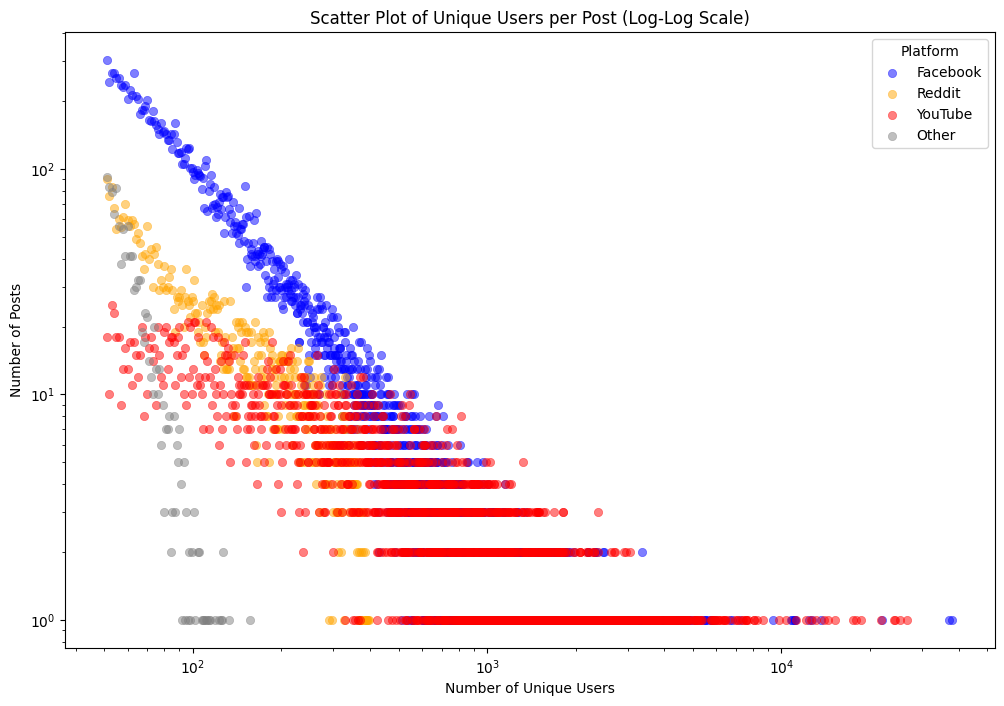

In [ ]:
# Group by 'post_id' and count unique 'user_id' for each platform
users_fb = fb.groupby('post_id')['user_id'].nunique().reset_index()
users_rd = rd.groupby('post_id')['user_id'].nunique().reset_index()
users_yt = yt.groupby('post_id')['user_id'].nunique().reset_index()
users_vo = vo.groupby('post_id')['user_id'].nunique().reset_index()

# Rename columns
users_fb.columns = ['post_id', 'user_count']
users_rd.columns = ['post_id', 'user_count']
users_yt.columns = ['post_id', 'user_count']
users_vo.columns = ['post_id', 'user_count']

# Filter to include only posts with more than 50 unique users
users_fb = users_fb[users_fb['user_count'] > 50]
users_rd = users_rd[users_rd['user_count'] > 50]
users_yt = users_yt[users_yt['user_count'] > 50]
users_vo = users_vo[users_vo['user_count'] > 50]

# Count the number of posts with a specific number of unique users
post_count_fb = users_fb.groupby('user_count').size().reset_index(name='post_count')
post_count_rd = users_rd.groupby('user_count').size().reset_index(name='post_count')
post_count_yt = users_yt.groupby('user_count').size().reset_index(name='post_count')
post_count_vo = users_vo.groupby('user_count').size().reset_index(name='post_count')

observed_fb = users_fb['user_count']
observed_rd= users_rd['user_count']
observed_yt= users_yt['user_count']
observed_vo= users_vo['user_count']

# Create the scatter plot with log-log scale
plt.figure(figsize=(12, 8))

# Scatter plot for the Facebook data
sns.scatterplot(data=post_count_fb, x='user_count', y='post_count', alpha=0.5, label='Facebook', color='blue', edgecolor=None)

# Scatter plot for the Reddit data
sns.scatterplot(data=post_count_rd, x='user_count', y='post_count', alpha=0.5, label='Reddit', color='orange', edgecolor=None)

# Scatter plot for the YouTube data
sns.scatterplot(data=post_count_yt, x='user_count', y='post_count', alpha=0.5, label='YouTube', color='red', edgecolor=None)

# Scatter plot for the Other data
sns.scatterplot(data=post_count_vo, x='user_count', y='post_count', alpha=0.5, label='Other', color='grey', edgecolor=None)

# Set the axes to log scale
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of Unique Users per Post (Log-Log Scale)')
plt.xlabel('Number of Unique Users')
plt.ylabel('Number of Posts')

# Remove the grid
plt.grid(False)

# Add the legend
plt.legend(title='Platform')
plt.show()

In [ ]:
observed_fb = users_fb['user_count']
observed_rd= users_rd['user_count']
observed_yt= users_yt['user_count']
observed_vo= users_vo['user_count']

0        252
1         75
2         85
3         55
4         77
        ... 
21393    100
21394    164
21395     57
21398     74
21399    150
Name: user_count, Length: 20248, dtype: int64

In [ ]:
# Funzione per stimare il parametro gamma usando il pacchetto powerlaw
def fit_power_law(data, xmin):
    fit = powerlaw.Fit(data, xmin=xmin, discrete=True)
    return fit.alpha


# Stima il parametro gamma per ciascuna distribuzione
xmin_fb = 50  # Valore minimo noto
gamma_fb = fit_power_law(observed_fb, xmin_fb)

xmin_rd = 50  # Valore minimo noto
gamma_rd = fit_power_law(observed_rd, xmin_rd)

xmin_yt = 50  # Valore minimo noto
gamma_yt = fit_power_law(observed_yt, xmin_yt)

xmin_vo = 50  # Valore minimo noto
gamma_vo = fit_power_law(observed_vo, xmin_vo)

print(f"Facebook: gamma = {gamma_fb}, xmin = {xmin_fb}")
print(f"Reddit: gamma = {gamma_rd}, xmin = {xmin_rd}")
print(f"YouTube: gamma = {gamma_yt}, xmin = {xmin_yt}")
print(f"Other: gamma = {gamma_vo}, xmin = {xmin_vo}")

Facebook: gamma = 1.920612852062878, xmin = 50
Reddit: gamma = 2.1172386372477376, xmin = 50
YouTube: gamma = 1.4925219530385783, xmin = 50
Other: gamma = 5.560174158235733, xmin = 50


Sample

In [ ]:
# Numero di campioni da generare per ogni piattaforma
sample_size = 1000

# Genera campioni dalla distribuzione di potenza stimata
simulated_fb = generate_power_law_samples(gamma_fb, 50, sample_size)
simulated_rd = generate_power_law_samples(gamma_rd, 50, sample_size)
simulated_yt = generate_power_law_samples(gamma_yt, 50, sample_size)
simulated_vo = generate_power_law_samples(gamma_vo, 50, sample_size)

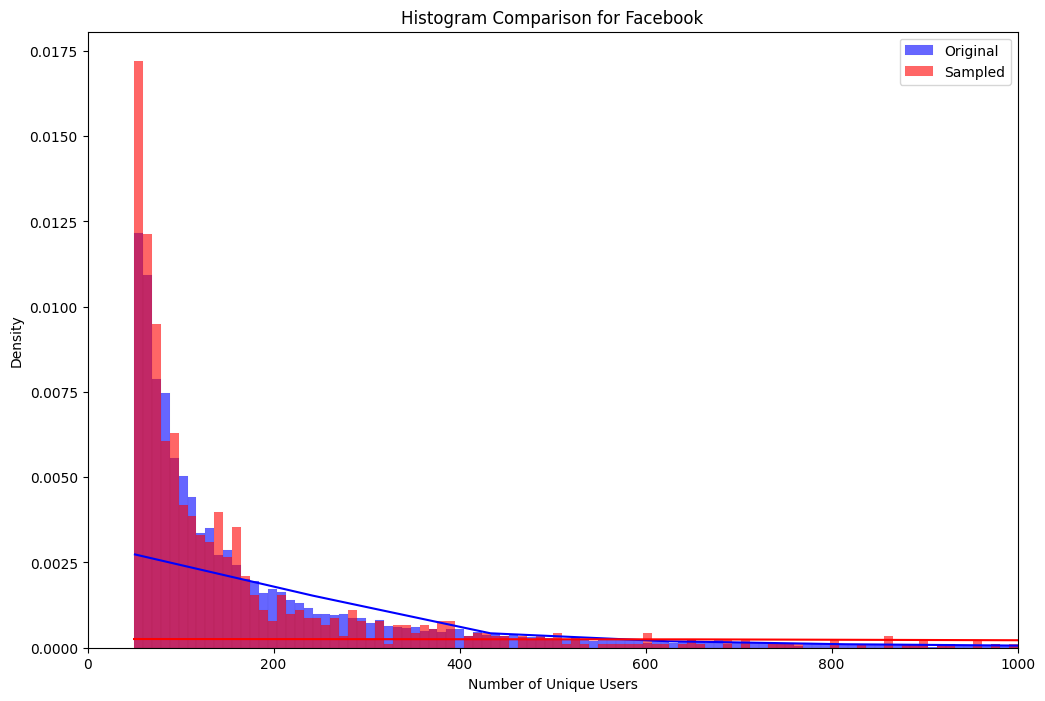

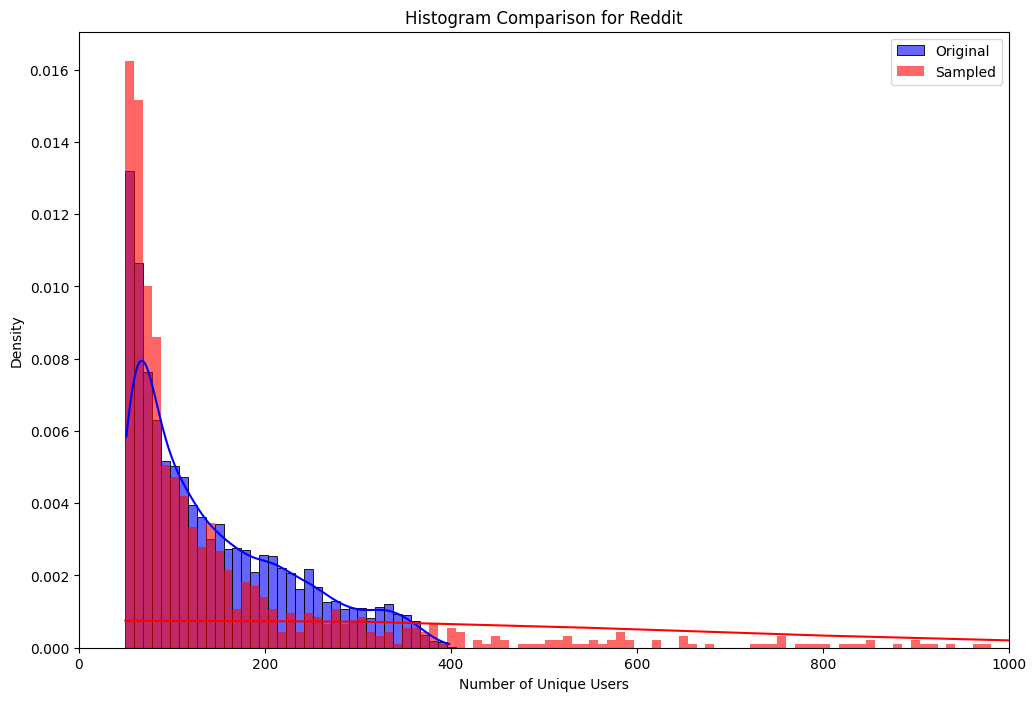

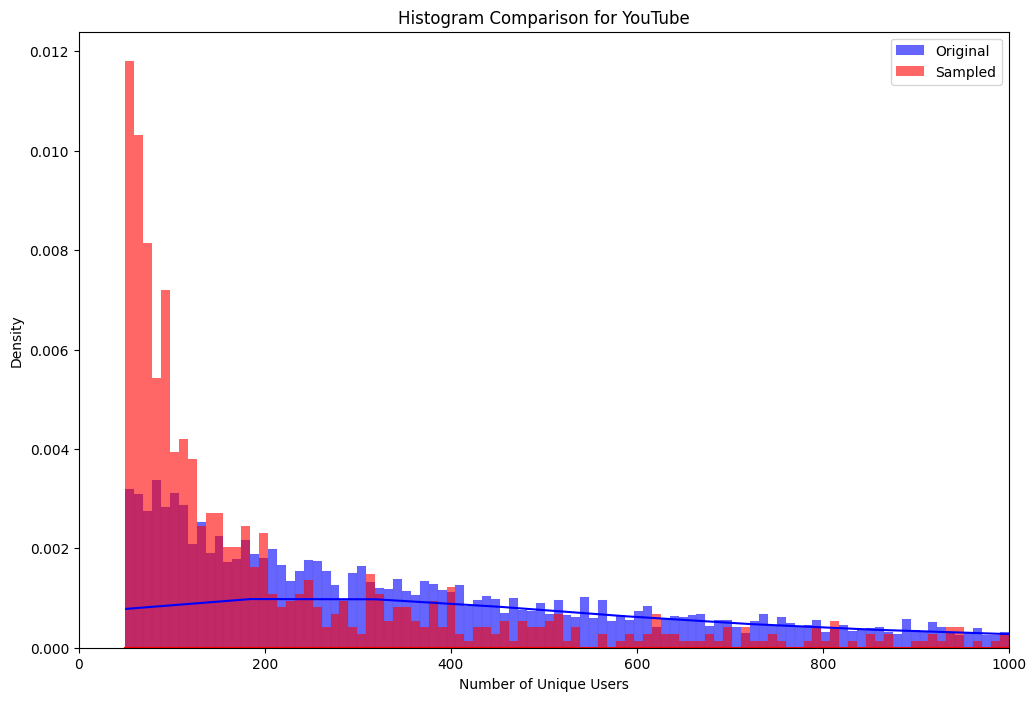

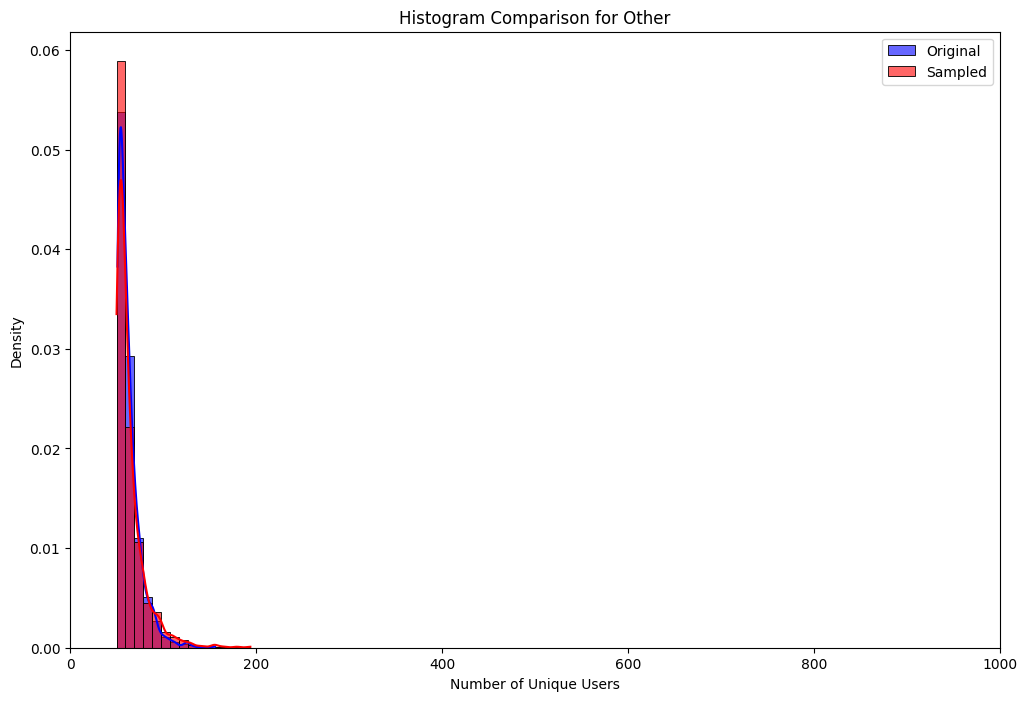

Loss for Facebook: 0.0274331706265818
Loss for Reddit: 0.041474229417080205
Loss for YouTube: 0.07032497875813491
Loss for Other: 0.01614631856198882


In [ ]:
# Funzione per creare istogrammi di confronto
def plot_histogram_comparison(original, sampled, platform_name, bins):
    plt.figure(figsize=(12, 8))
    sns.histplot(original, kde=True, color='blue', label='Original', bins=bins, stat='density', alpha=0.6)
    sns.histplot(sampled, kde=True, color='red', label='Sampled', bins=bins, stat='density', alpha=0.6)
    plt.title(f'Histogram Comparison for {platform_name}')
    plt.xlabel('Number of Unique Users')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(0,max(bins))
    plt.show()

# Funzione per calcolare la perdita come somma delle differenze di frequenza bin per bin
def calculate_frequency_difference_loss(original, sampled, bins):
    # Handling NaN values in original and sampled data

    # Compute histograms
    sampled_hist, _ = np.histogram(sampled, bins=bins, density=True)
    original_hist, _ = np.histogram(original, bins=bins, density=True)

    # Calculate loss
    loss = np.sum(np.abs(original_hist - sampled_hist))

    return loss
# Definire il numero di bins
bins = np.linspace(50, 1000, 100)



# Creare istogrammi di confronto per ciascuna piattaforma
plot_histogram_comparison(observed_fb, simulated_fb, 'Facebook',bins)
plot_histogram_comparison(observed_rd, simulated_rd, 'Reddit',bins)
plot_histogram_comparison(observed_yt, simulated_yt, 'YouTube',bins)
plot_histogram_comparison(observed_vo, simulated_vo, 'Other',bins)

# Calcolare la perdita per ciascuna piattaforma
loss_fb = calculate_frequency_difference_loss(observed_fb, simulated_fb, bins)
loss_rd = calculate_frequency_difference_loss(observed_rd, simulated_rd, bins)
loss_yt = calculate_frequency_difference_loss(observed_yt, simulated_yt, bins)
loss_vo = calculate_frequency_difference_loss(observed_vo, simulated_vo, bins)

print(f'Loss for Facebook: {loss_fb}')
print(f'Loss for Reddit: {loss_rd}')
print(f'Loss for YouTube: {loss_yt}')
print(f'Loss for Other: {loss_vo}')

In [ ]:
params_dict = {}
def fit_power_law(data, xmin):
    fit = powerlaw.Fit(data, xmin=xmin, discrete=True)
    return fit.alpha


# Stima il parametro gamma per ciascuna distribuzione
xmin_fb = 50  # Valore minimo noto
gamma_fb = fit_power_law(observed_fb, xmin_fb)
params_dict['fb']['gamma']=gamma_fb

xmin_rd = 50  # Valore minimo noto
gamma_rd = fit_power_law(observed_rd, xmin_rd)
params_dict['rd']['gamma']=gamma_rd

xmin_yt = 50  # Valore minimo noto
gamma_yt = fit_power_law(observed_yt, xmin_yt)
params_dict['yt']['gamma']=gamma_yt

xmin_vo = 50  # Valore minimo noto
gamma_vo = fit_power_law(observed_vo, xmin_vo)
params_dict['vo']['gamma']=gamma_vo


KeyError: 'fb'

### T0

In [ ]:
lista_dei_social=[fbt,fbn]
nomi_dei_social=['fbt','fbn']
from scipy.stats import beta

# Function to fit beta distribution and return parameters
def fit_beta_distribution(data):
    data = data[data > 0]  # Filter out zero or negative values
    a, b, loc, scale = beta.fit(data  )# ,floc=0, fscale=1)
    return {'a': a, 'b': b, 'loc': loc, 'scale': scale}

# Example data fitting for each social media platform
params_dict = {}

# Example data fitting for YouTube (yt)
print('Starting fbt')
social=fbt
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
yt_params = fit_beta_distribution(data)
params_dict['fbt'] = yt_params

# Example data fitting for Facebook (fb)
print('Starting fbn')
social=fbn
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
fb_params = fit_beta_distribution(data)
params_dict['fbn'] = fb_params

# Example data fitting for Reddit (rd)
print('Starting rd')
social=rd
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
rd_params = fit_beta_distribution(data)
params_dict['rd'] = rd_params

# Example data fitting for Voat (vo)
print('Starting vo')
social=vo
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
vo_params = fit_beta_distribution(data)
params_dict['vo'] = vo_params

# Display the parameters
for social, params in params_dict.items():
    print(f"{social}:")
    print(f"  Shape parameter (a): {params['a']}")
    print(f"  Shape parameter (b): {params['b']}")
    print(f"  Location parameter: {params['loc']}")
    print(f"  Scale parameter: {params['scale']}")
    print()



Starting fbt


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Starting fbn
Starting rd


Shape parameter (a): 0.5015105408216343
Shape parameter (b): 5.630144935875129
Location parameter: 0
Scale parameter: 1


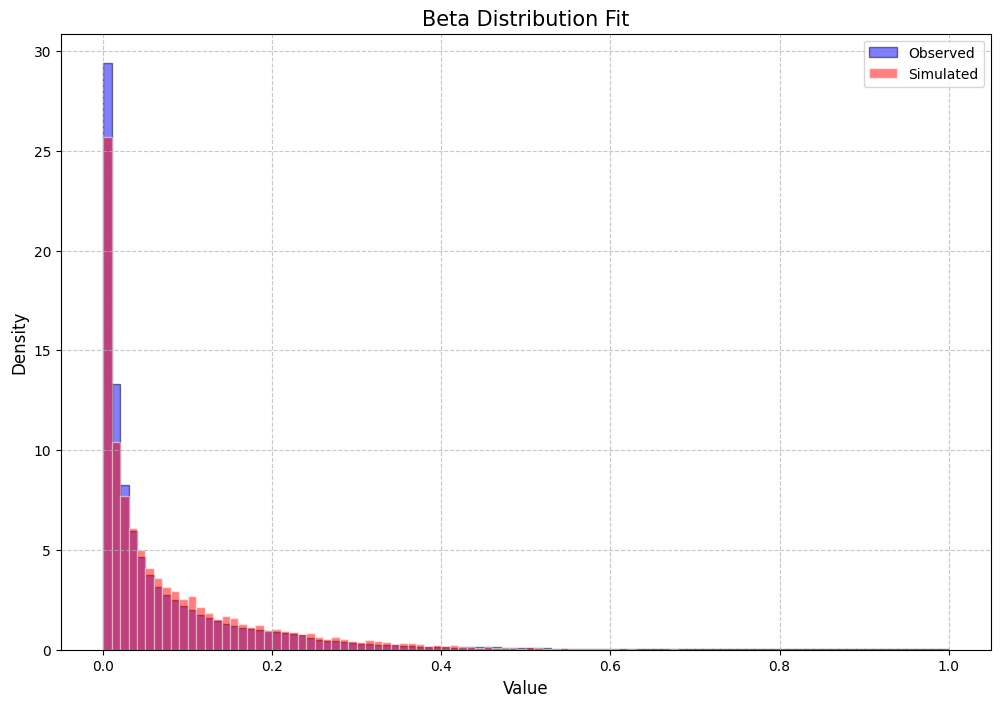

In [ ]:


social=fb
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
a=fb_params['a']
b=fb_params['b']
loc=fb_params['loc']
scale=fb_params['scale']




simulated = beta.rvs(a, b, loc=loc, scale=scale, size=10000)
print("Shape parameter (a):", a)
print("Shape parameter (b):", b)
print("Location parameter:", loc)
print("Scale parameter:", scale)

# Plot histogram
plt.figure(figsize=(12, 8))
bins = np.linspace(0, 1, 101)
plt.hist(data, bins, alpha=0.5, label='Observed', color='blue', density=True, edgecolor='black')


plt.hist(simulated, bins, alpha=0.5, label='Simulated', color='red', density=True, edgecolor='white')


# Labels, title, legend, etc.
plt.title('Beta Distribution Fit', fontsize=15)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()



#### Observed data from different platforms

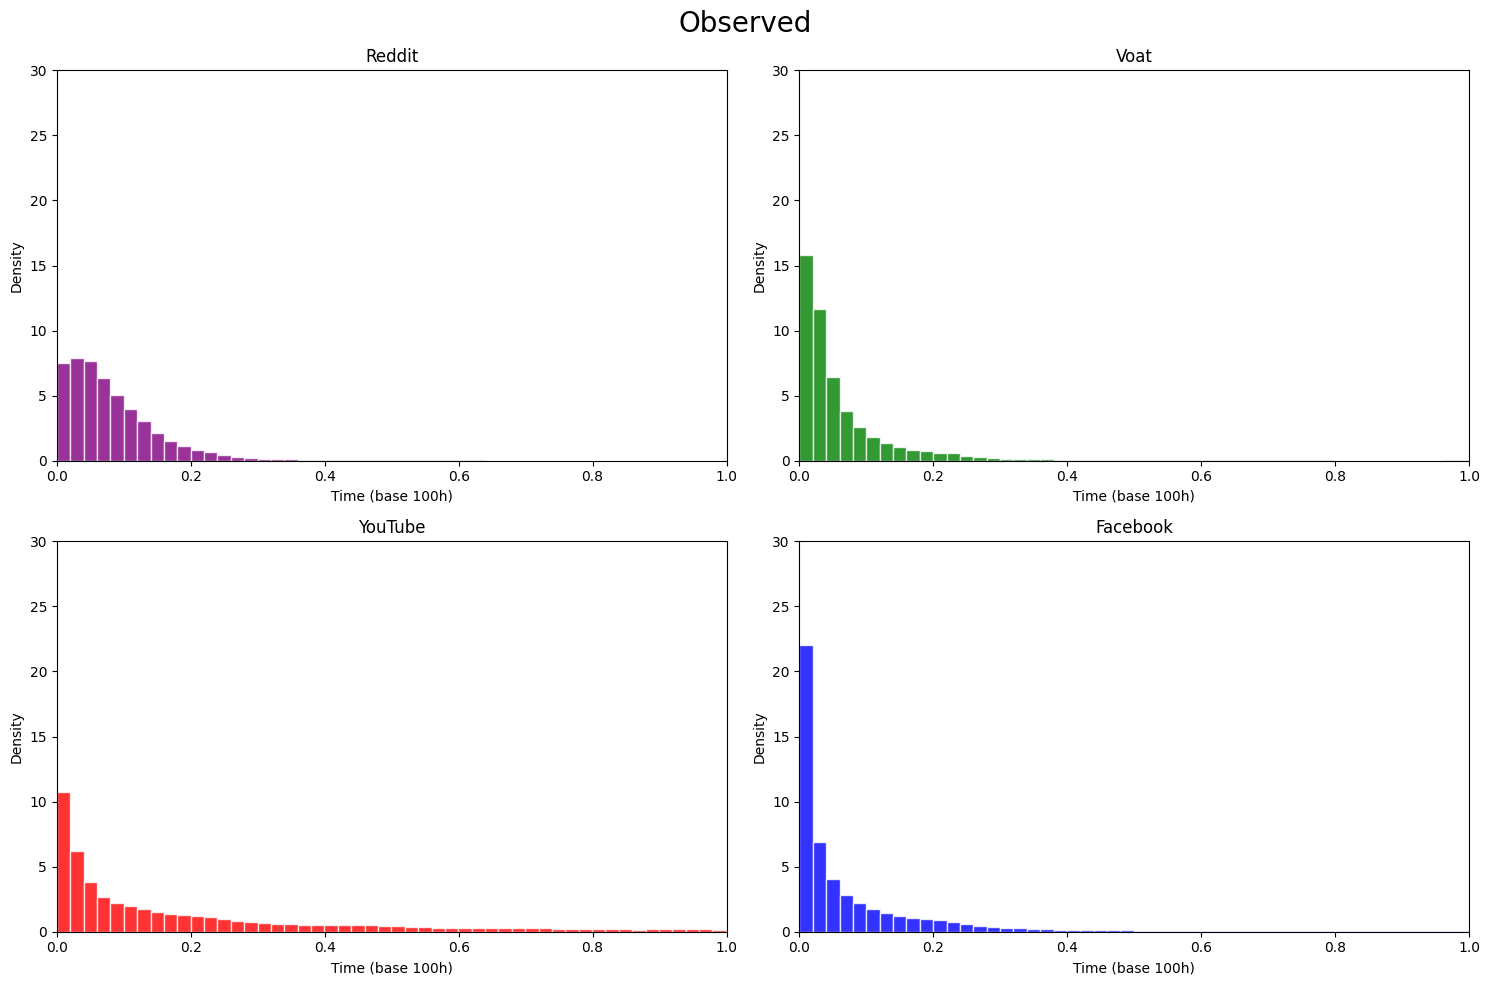

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Assume fb, rd, yt, vo are already defined dataframes with the required data columns

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define common x and y limits
xlim = (0, 1)
ylim = (0, 30)  # Adjust based on the data for appropriate scaling
  # Adjust based on the data for appropriate scaling

# Plot histograms for the different distributions in separate subplots

# Reddit
axes[0, 0].hist(rd['temporal_distance_birth_base_100h'], bins=50, alpha=0.8, label='Reddit', color='purple', density=True, edgecolor='white')
axes[0, 0].set_title('Reddit')
axes[0, 0].set_xlim(xlim)
axes[0, 0].set_ylim(ylim)
axes[0, 0].set_xlabel('Time (base 100h)')
axes[0, 0].set_ylabel('Density')

# Voat
axes[0, 1].hist(vo['temporal_distance_birth_base_100h'], bins=50, alpha=0.8, label='Voat', color='green', density=True, edgecolor='white')
axes[0, 1].set_title('Voat')
axes[0, 1].set_xlim(xlim)
axes[0, 1].set_ylim(ylim)
axes[0, 1].set_xlabel('Time (base 100h)')
axes[0, 1].set_ylabel('Density')

# YouTube
axes[1, 0].hist(yt['temporal_distance_birth_base_100h'], bins=50, alpha=0.8, label='YouTube', color='red', density=True, edgecolor='white')
axes[1, 0].set_title('YouTube')
axes[1, 0].set_xlim(xlim)
axes[1, 0].set_ylim(ylim)
axes[1, 0].set_xlabel('Time (base 100h)')
axes[1, 0].set_ylabel('Density')

# Facebook
axes[1, 1].hist(fb['temporal_distance_birth_base_100h'], bins=50, alpha=0.8, label='Facebook', color='blue', density=True, edgecolor='white')
axes[1, 1].set_title('Facebook')
axes[1, 1].set_xlim(xlim)
axes[1, 1].set_ylim(ylim)
axes[1, 1].set_xlabel('Time (base 100h)')
axes[1, 1].set_ylabel('Density')
# Adjust layout and add a single large title for all four subplots
fig.suptitle('Observed', fontsize=20)
plt.tight_layout()

# Show the plot
plt.show()


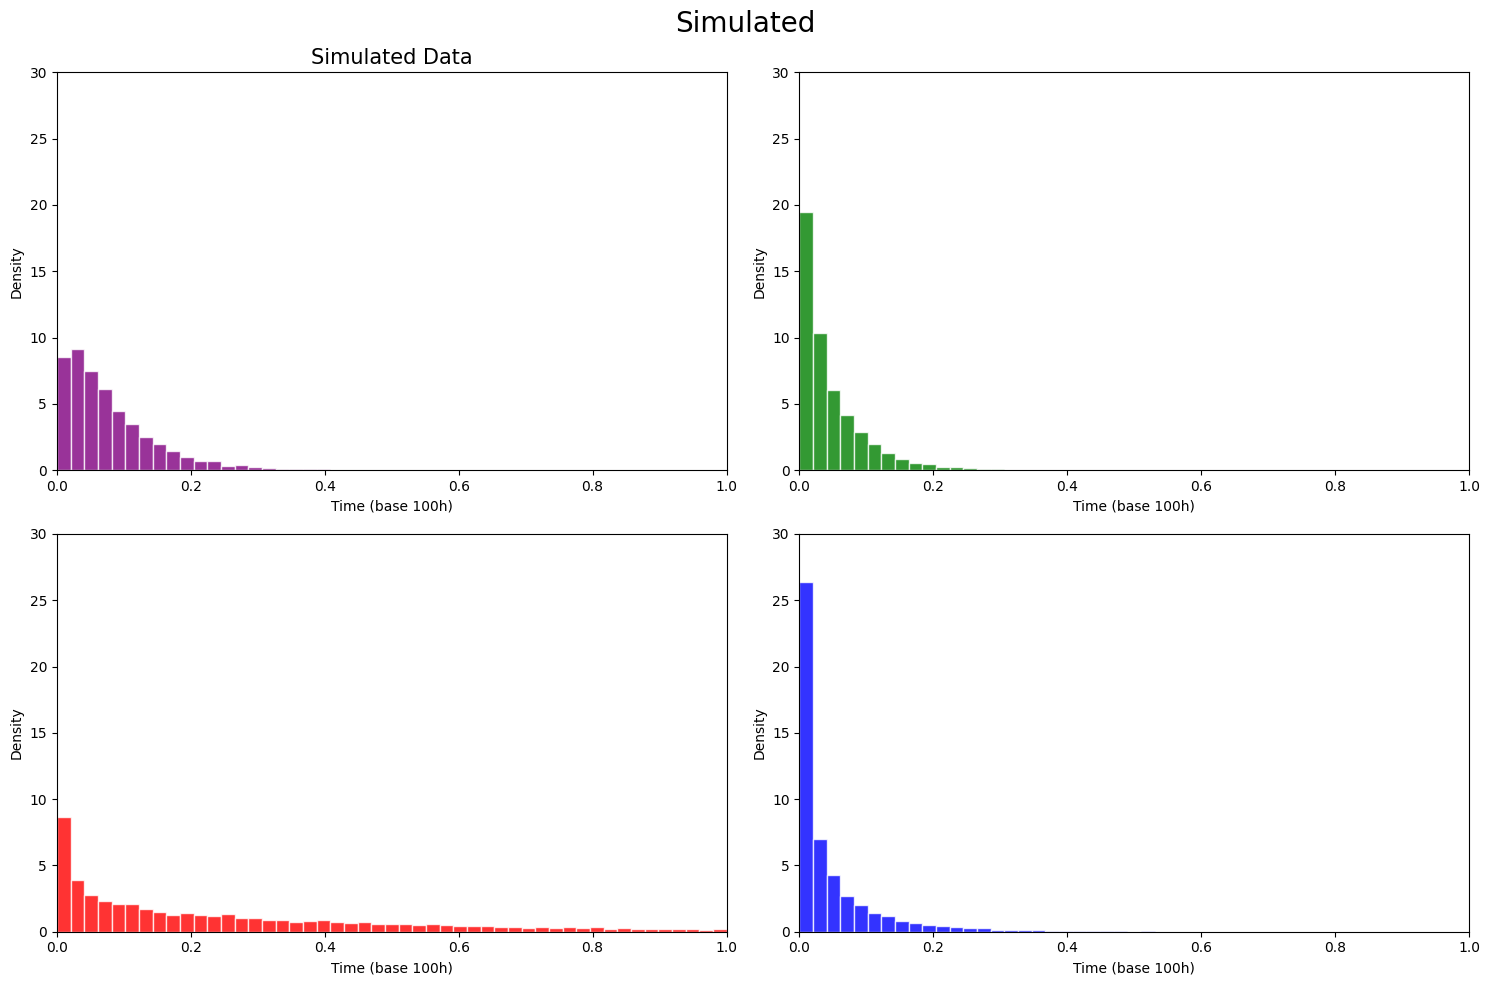

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Number of samples to draw from each distribution
num_samples = 10000

# Sample from each beta distribution (replace with your actual parameters)
samples_rd = beta.rvs(params_dict['rd']['a'], params_dict['rd']['b'], loc=params_dict['rd']['loc'], scale=params_dict['rd']['scale'], size=num_samples)
samples_vo = beta.rvs(params_dict['vo']['a'], params_dict['vo']['b'], loc=params_dict['vo']['loc'], scale=params_dict['vo']['scale'], size=num_samples)
samples_yt = beta.rvs(params_dict['yt']['a'], params_dict['yt']['b'], loc=params_dict['yt']['loc'], scale=params_dict['yt']['scale'], size=num_samples)
samples_fb = beta.rvs(params_dict['fb']['a'], params_dict['fb']['b'], loc=params_dict['fb']['loc'], scale=params_dict['fb']['scale'], size=num_samples)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define common x and y limits
xlim = (0, 1)
ylim = (0, 30)  # Adjust based on the data for appropriate scaling

# Plot histograms for the different distributions in separate subplots

# Reddit
axes[0, 0].hist(samples_rd, bins=np.linspace(0, 1, 50), alpha=0.8, label='Reddit', color='purple', density=True, edgecolor='white')
axes[0, 0].set_title('Simulated Data', fontsize=15)
axes[0, 0].set_xlim(xlim)
axes[0, 0].set_ylim(ylim)
axes[0, 0].set_xlabel('Time (base 100h)')
axes[0, 0].set_ylabel('Density')

# Voat
axes[0, 1].hist(samples_vo, bins=np.linspace(0, 1, 50), alpha=0.8, label='Voat', color='green', density=True, edgecolor='white')
axes[0, 1].set_xlim(xlim)
axes[0, 1].set_ylim(ylim)
axes[0, 1].set_xlabel('Time (base 100h)')
axes[0, 1].set_ylabel('Density')

# YouTube
axes[1, 0].hist(samples_yt, bins=np.linspace(0, 1, 50), alpha=0.8, label='YouTube', color='red', density=True, edgecolor='white')
axes[1, 0].set_xlim(xlim)
axes[1, 0].set_ylim(ylim)
axes[1, 0].set_xlabel('Time (base 100h)')
axes[1, 0].set_ylabel('Density')

# Facebook
axes[1, 1].hist(samples_fb, bins=np.linspace(0, 1, 50), alpha=0.8, label='Facebook', color='blue', density=True, edgecolor='white')
axes[1, 1].set_xlim(xlim)
axes[1, 1].set_ylim(ylim)
axes[1, 1].set_xlabel('Time (base 100h)')
axes[1, 1].set_ylabel('Density')

# Adjust layout and add a single large title for all four subplots
fig.suptitle('Simulated', fontsize=20)
plt.tight_layout()

# Show the plot
plt.show()


#### Teoretical distributions

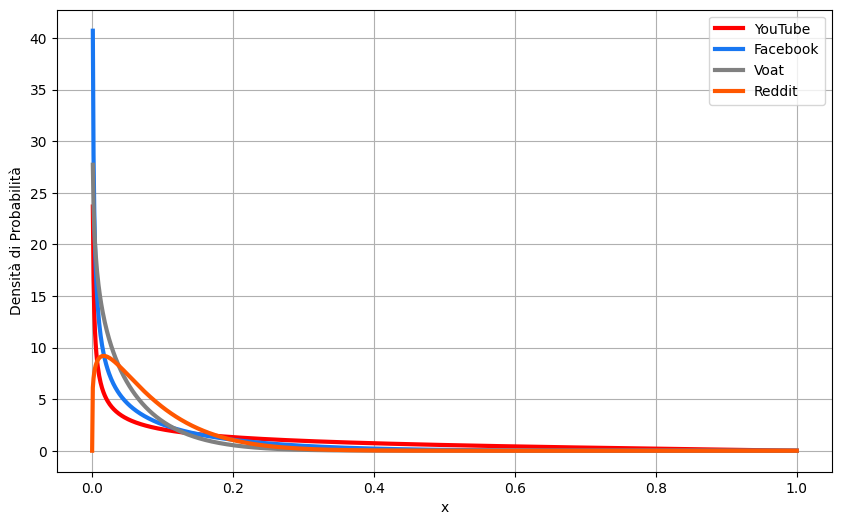

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Generiamo una griglia di valori x per il plot
x = np.linspace(0, 1, 1000)

# Calcoliamo la densità di probabilità (PDF) della distribuzione beta
pdf_beta1 = beta.pdf(x, 0.49, 1.85)
pdf_beta2 = beta.pdf(x, 0.5, 5.5)
pdf_beta3 = beta.pdf(x, 0.8, 14)
pdf_beta4 = beta.pdf(x, 1.22, 14.25)

# Plot della distribuzione beta
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_beta1, color='#FF0000', lw=3, label='YouTube')   # Red for YouTube
plt.plot(x, pdf_beta2, color='#1877F2', lw=3, label='Facebook')  # Facebook blue
plt.plot(x, pdf_beta3, color='grey', lw=3, label='Voat')      # Orange for Voat
plt.plot(x, pdf_beta4, color='#FF5700', lw=3, label='Reddit')    # Reddit orange-red

plt.xlabel('x')
plt.ylabel('Densità di Probabilità')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### ZIE

In [ ]:
def simulate_number_of_comments(alpha, lambda_,):
    # Simula la componente inflazionata (produce 0 con probabilità alpha)
    inflate = np.random.binomial(1, alpha, 1)
    # Simula la componente contatore (distribuzione esponenziale negativa)
    counts = np.random.exponential(1/lambda_, 1)
    # Discretizza i valori esponenziali per ottenere valori di conteggio interi
    counts = np.round(counts).astype(int)
    counts[counts<0]=0
    # Combina le componenti inflazionate e di conteggio
    simulated_data = inflate * (counts)
    return simulated_data
def simulate_zip(alpha, lambda_, size=10000):
    # Simula la componente inflazionata (produce 0 con probabilità alpha)
    inflate = np.random.binomial(1, alpha, size)
    # Simula la componente contatore (distribuzione esponenziale negativa)
    counts = np.random.exponential(1/lambda_, size)
    # Discretizza i valori esponenziali per ottenere valori di conteggio interi
    counts = np.round(counts).astype(int)
    counts[counts<0]=0
    # Combina le componenti inflazionate e di conteggio
    simulated_data = inflate * counts
    return simulated_data

# Function to calculate KL-divergence
def kl_divergence(p, q):
    epsilon = 1e-10  # Small constant to avoid log(0)
    return np.sum(p * np.log((p + epsilon) / (q + epsilon)))

In [ ]:



for i,social in tqdm(enumerate(lista_dei_social),total=len(lista_dei_social)):
  size_of_interaction = social.groupby(['user_id', 'post_id'])['comment_id'].count().reset_index()
  observed_data =size_of_interaction['comment_id']-1
  observed_data=observed_data[observed_data<1000]
  # Grid search parameters
  alpha_range = np.linspace(0, 1, 10)  # Range of alpha values to try
  lambda_range = np.arange(0.1, 2, 0.2)  # Range of lambda values to try

  best_alpha = None
  best_lambda = None
  best_loss = np.inf

  # Perform grid search
  for alpha in (alpha_range):
      for lambda_ in lambda_range:
          # Simulate data based on current parameters
          simulated_data = simulate_zip(alpha, lambda_, size=len(observed_data))

          # Compute observed and simulated counts up to the maximum observed value
          max_value = max(np.max(observed_data), np.max(simulated_data))
          observed_counts = np.bincount(observed_data, minlength=max_value + 1)
          simulated_counts = np.bincount(simulated_data, minlength=max_value + 1)

          # Normalize distributions
          observed_distribution = observed_counts / np.sum(observed_counts)
          simulated_distribution = simulated_counts / np.sum(simulated_counts)

          # Calculate KL-divergence
          loss = kl_divergence(observed_distribution, simulated_distribution)

          # Check if current parameters give a better fit
          if loss < best_loss:
              best_loss = loss
              best_alpha = alpha
              best_lambda = lambda_
  params_dict[nomi_dei_social[i]]['alpha']=best_alpha
  params_dict[nomi_dei_social[i]]['lambda']=best_lambda
  print(best_loss)



NameError: name 'lista_dei_social' is not defined

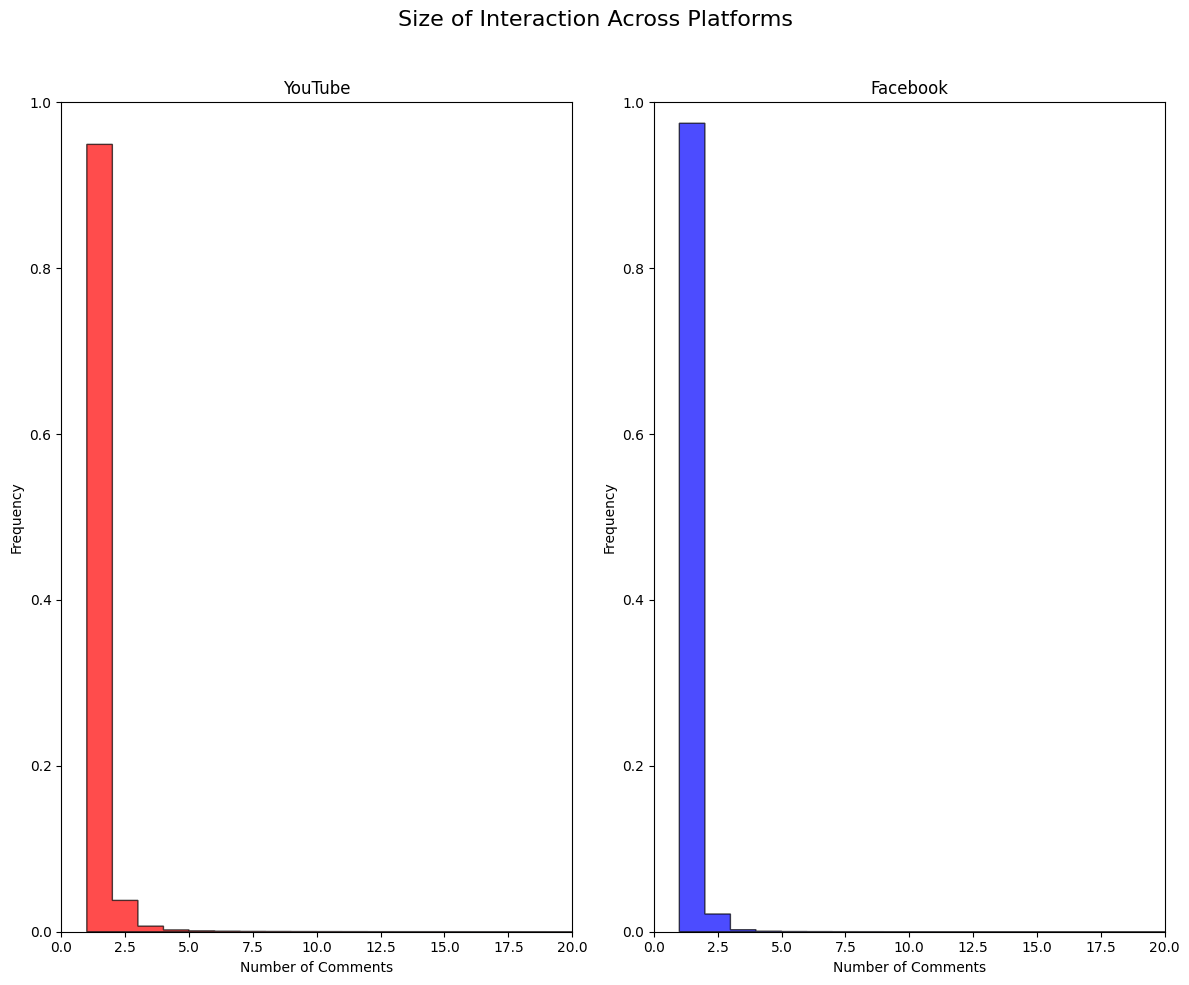

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che fbt e fbn siano DataFrame già definiti

bins = np.arange(1, 1000)

# Creare subplot con due grafici affiancati
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# YouTube
size_of_interaction_youtube = fbt.groupby(['user_id', 'post_id'])['comment_id'].count().reset_index()
axs[0].hist(size_of_interaction_youtube['comment_id'], bins=bins, alpha=0.7, edgecolor='black', color='red', histtype='stepfilled', density=True)
axs[0].set_title('YouTube')
axs[0].set_xlim(0, 20)
axs[0].set_xlabel('Number of Comments')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0, 1)

# Facebook
size_of_interaction_facebook = fbn.groupby(['user_id', 'post_id'])['comment_id'].count().reset_index()
axs[1].hist(size_of_interaction_facebook['comment_id'], bins=bins, alpha=0.7, edgecolor='black', color='blue', histtype='stepfilled', density=True)
axs[1].set_title('Facebook')
axs[1].set_xlim(0, 20)
axs[1].set_xlabel('Number of Comments')
axs[1].set_ylabel('Frequency')
axs[1].set_ylim(0, 1)

# Titolo principale e layout
fig.suptitle('Size of Interaction Across Platforms', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
bins = np.arange(1, 1000)

# Creare subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# YouTube
axs[0, 0].hist(yt_size_of_interaction, bins=bins, alpha=0.7, edgecolor='black', color='red', histtype='stepfilled', density=True)
axs[0, 0].set_title('YouTube')
axs[0, 0].set_xlim(0, 20)
axs[0, 0].set_xlabel('Number of Comments')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_ylim(0, 1)

# Facebook
axs[0, 1].hist(fb_size_of_interaction, bins=bins, alpha=0.7, edgecolor='black', color='blue', histtype='stepfilled', density=True)
axs[0, 1].set_title('Facebook')
axs[0, 1].set_xlabel('Number of Comments')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_xlim(0, 20)
axs[0, 1].set_ylim(0, 1)

# Reddit
axs[1, 0].hist(rd_size_of_interaction, bins=bins, alpha=0.7, edgecolor='black', color='orange', histtype='stepfilled', density=True)
axs[1, 0].set_title('Reddit')
axs[1, 0].set_xlim(0, 20)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlabel('Number of Comments')
axs[1, 0].set_ylabel('Frequency')

# Voat
axs[1, 1].hist(vo_size_of_interaction, bins=bins, alpha=0.7, edgecolor='black', color='green', histtype='stepfilled', density=True)
axs[1, 1].set_title('Voat')
axs[1, 1].set_xlim(0, 20)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xlabel('Number of Comments')
axs[1, 1].set_ylabel('Frequency')

# Titolo principale e layout
fig.suptitle('Size of Interaction Across Platforms', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

ValueError: The 'color' keyword argument must have one color per dataset, but 3 datasets and 1 colors were provided

Error in callback <function _draw_all_if_interactive at 0x7ace294a7d90> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ace294a7010> (for post_execute):


KeyboardInterrupt: 

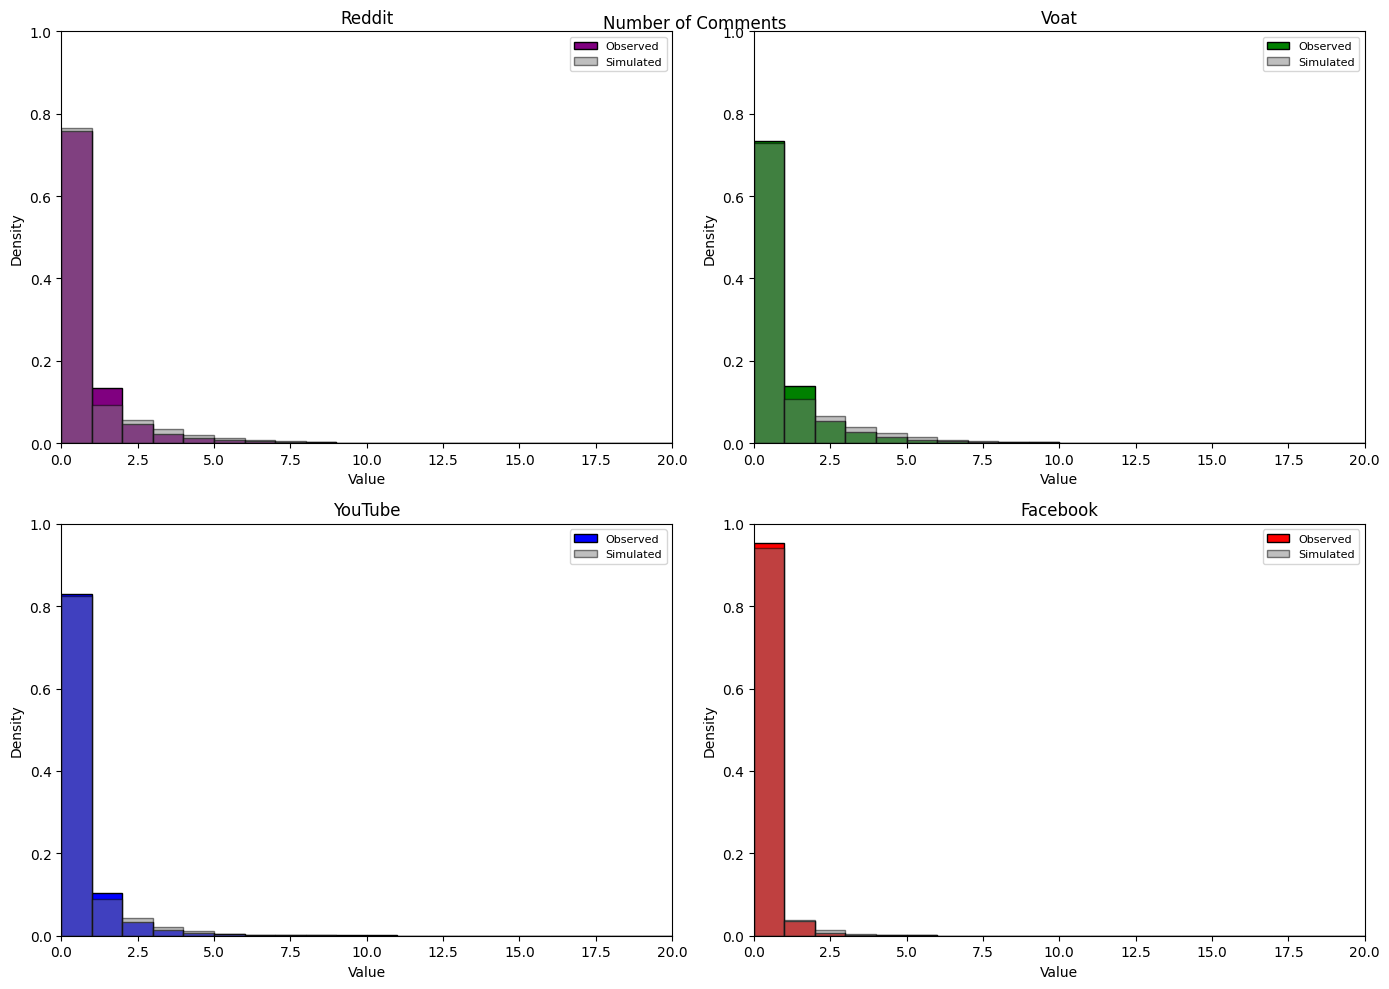

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have functions simulate_zip and params_dict defined

# Simulate data with best parameters for four different datasets

names = ['rd','vo','yt','fb'] # Order corresponds to colors
titles = ['Reddit','Voat','YouTube','Facebook']
datasets = [rd,vo,yt,fb]
plt.figure(figsize=(12, 10))  # Adjust size as per your preference

colors = ['purple', 'green','blue',  'red']  # Colors for fb, rd, vo, yt respectively
i=0
for name in names:

    dataset=datasets[i]
    title=titles[i]
    i+=1
    best_alpha = params_dict[name]['alpha']
    best_lambda = params_dict[name]['lambda']

    # Assuming you have the necessary data processing steps similar to 'fb'
    size_of_interaction = dataset.groupby(['user_id', 'post_id'])['comment_id'].count().reset_index()
    observed_data = size_of_interaction['comment_id'] - 1
    observed_data = observed_data[observed_data < 1000]

    simulated_data = simulate_zip(best_alpha, best_lambda, size=len(observed_data))

    # Plotting each subplot
    plt.subplot(2, 2, i)

    # Plot observed data in violet for reddit, green for voat, red for yt, blue for facebook
    plt.hist(observed_data, bins=np.arange(0, np.max(observed_data) + 1, 1), alpha=1, label='Observed', color=colors[i-1], density=True, edgecolor='black')

    # Plot simulated data in grey
    plt.hist(simulated_data, bins=np.arange(0, np.max(observed_data) + 1, 1), alpha=0.5, label='Simulated', color='grey', density=True, edgecolor='black')

    # Labels, title, legend, etc.
    plt.title(f'{title}', fontsize=12)
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend(loc='upper right', fontsize=8)
    plt.xlim(0, 20)  # Adjust x-axis limits as needed
    plt.ylim(0, 1)
    plt.tight_layout()

plt.suptitle('Number of Comments', fontsize=12)
plt.show()


In [ ]:
for name in names:

    dataset=datasets[i]
    i+=1
    best_alpha = params_dict[name]['alpha']
    best_lambda = params_dict[name]['lambda']

### IAT

In [ ]:
import pandas as pd

def process_platform(df, platform_name):
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_comments_by_user_in_thread'].copy()
  df=df.dropna(subset='IAT_user_thread').copy()
  df['time_difference']=df['IAT_user_thread']/(60*60*100)
  merged_df=df[df['last_comment']==False].copy()
  merged_df_final=df[df['last_comment']==True].copy()
  return merged_df,merged_df_final

# Process Facebook
IAT_fb,IAT_f_fb = process_platform(fb, 'Facebook')

# Process Reddit
IAT_rd,IAT_f_rd = process_platform(rd, 'Reddit')

# Process YouTube
yt['user_id']=yt['user']
IAT_yt,IAT_f_yt = process_platform(yt, 'YouTube')

# Process Voat
vo['user_id']=vo['user']
vo['post_id']=vo['root_submission']
IAT_vo,IAT_f_vo = process_platform(vo, 'Voat')



In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import burr
import matplotlib.pyplot as plt

# Supponiamo che 'merged_rd' sia il DataFrame e 'time_difference' la colonna contenente i dati osservati

# Step 1: Normalizzare i dati (come hai fatto prima)
for i,IAT in tqdm(enumerate([(IAT_fb,IAT_f_fb),(IAT_rd,IAT_f_rd),(IAT_yt,IAT_f_yt),(IAT_vo,IAT_f_vo)]),total=4):
  data = IAT[0]['time_difference']
  data = data[data > 0]  # Rimuovere i valori non positivi
  data_min = data.min()
  data_max = data.max()
  c, d, l, s = burr.fit(data)

  data = IAT[1]['time_difference']
  data = data[data > 0]  # Rimuovere i valori non positivi
  data_min = data.min()
  data_max = data.max()
  cf,df,lf,sf= burr.fit(data)

  params_dict[nomi_dei_social[i]]['c']=c
  params_dict[nomi_dei_social[i]]['d']=d
  params_dict[nomi_dei_social[i]]['l']=l
  params_dict[nomi_dei_social[i]]['s']=s

  params_dict[nomi_dei_social[i]]['cf']=cf
  params_dict[nomi_dei_social[i]]['df']=df
  params_dict[nomi_dei_social[i]]['lf']=lf
  params_dict[nomi_dei_social[i]]['sf']=sf





100%|██████████| 4/4 [04:26<00:00, 66.69s/it]


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import burr
import matplotlib.pyplot as plt

# Supponiamo che 'merged_rd' sia il DataFrame e 'time_difference' la colonna contenente i dati osservati

# Step 1: Normalizzare i dati (come hai fatto prima)
for i,IAT in tqdm(enumerate([(IAT_fbt,IAT_f_fbt),(IAT_fbn,IAT_f_fbn)]),total=2):
  data = IAT[0]['time_difference']
  data = data[data > 0]  # Rimuovere i valori non positivi
  data_min = data.min()
  data_max = data.max()
  c, d, l, s = burr.fit(data)

  data = IAT[1]['time_difference']
  data = data[data > 0]  # Rimuovere i valori non positivi
  data_min = data.min()
  data_max = data.max()
  cf,df,lf,sf= burr.fit(data)

  params_dict[nomi_dei_social[i]]['c']=c
  params_dict[nomi_dei_social[i]]['d']=d
  params_dict[nomi_dei_social[i]]['l']=l
  params_dict[nomi_dei_social[i]]['s']=s

  params_dict[nomi_dei_social[i]]['cf']=cf
  params_dict[nomi_dei_social[i]]['df']=df
  params_dict[nomi_dei_social[i]]['lf']=lf
  params_dict[nomi_dei_social[i]]['sf']=sf





{'fbt': {'a': 0.7115277582927078,
  'b': 281.6066881348786,
  'loc': 0.0009999999999999998,
  'scale': 13.31164305704661,
  'alpha': 0.1111111111111111,
  'lambda': 1.1000000000000003,
  'c': 1.492977851904907,
  'd': 0.08817579984640152,
  'l': 2.7777777777777775e-06,
  's': 1.3437549624022926,
  'cf': 1.1576556213689384,
  'df': 0.11915596237680365,
  'lf': 2.7777777777777775e-06,
  'sf': 1.2461739211730007},
 'fbn': {'a': 0.5240815837147368,
  'b': 204.29275508410842,
  'loc': 0.0009999999999999998,
  'scale': 24.907322247979135,
  'alpha': 0.1111111111111111,
  'lambda': 1.9000000000000004,
  'c': 0.20859500006643816,
  'd': 0.9896055635216472,
  'l': 2.7777777777777775e-06,
  's': 1.2104864314577957,
  'cf': 0.19941367270549148,
  'df': 0.9089286564496282,
  'lf': 2.7777777777777775e-06,
  'sf': 1.4465571301983164}}

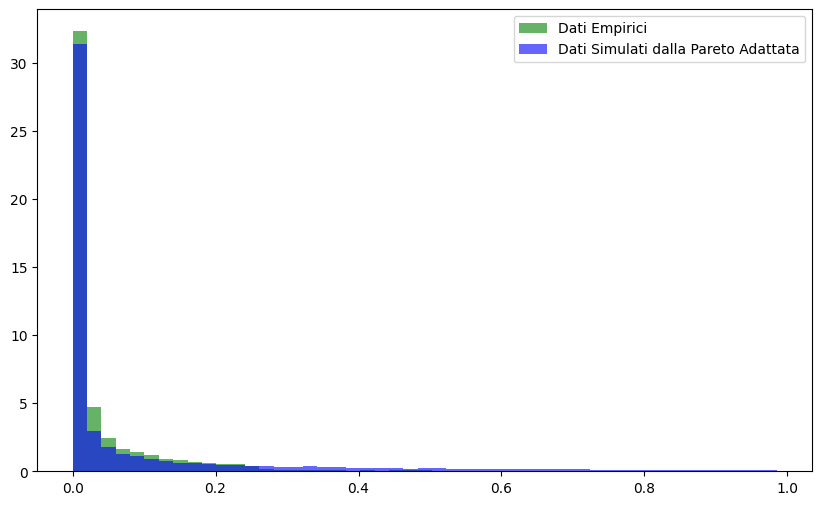

Loss: 31.700749479847808


In [ ]:
# Step 3: Generare dati sintetici dalla distribuzione Burr adattata
synthetic_data = burr.rvs(params_dict['fb']['c'], params_dict['fb']['d'], params_dict['fb']['l'], params_dict['fb']['s'], size=len(data))


# Step 4: Tracciare gli istogrammi con gli stessi bin
plt.figure(figsize=(10, 6))
# Definire i bin basati sull'intervallo dei dati empirici
bins = np.linspace(data_min, data_max, 50)
# Calcola gli istogrammi e le densità
hist_empirical, _ = np.histogram(IAT_fb['time_difference'], bins=bins, density=True)
hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)

# Calcola la loss come somma delle differenze di frequenza assolute
loss = np.sum(np.abs(hist_empirical - hist_synthetic))

# Visualizza gli istogrammi
plt.hist(data, bins=bins, density=True, alpha=0.6, color='g', label='Dati Empirici')
plt.hist(synthetic_data, bins=bins, density=True, alpha=0.6, color='b', label='Dati Simulati dalla Pareto Adattata')
plt.legend()
plt.show()

print(f'Loss: {loss}')


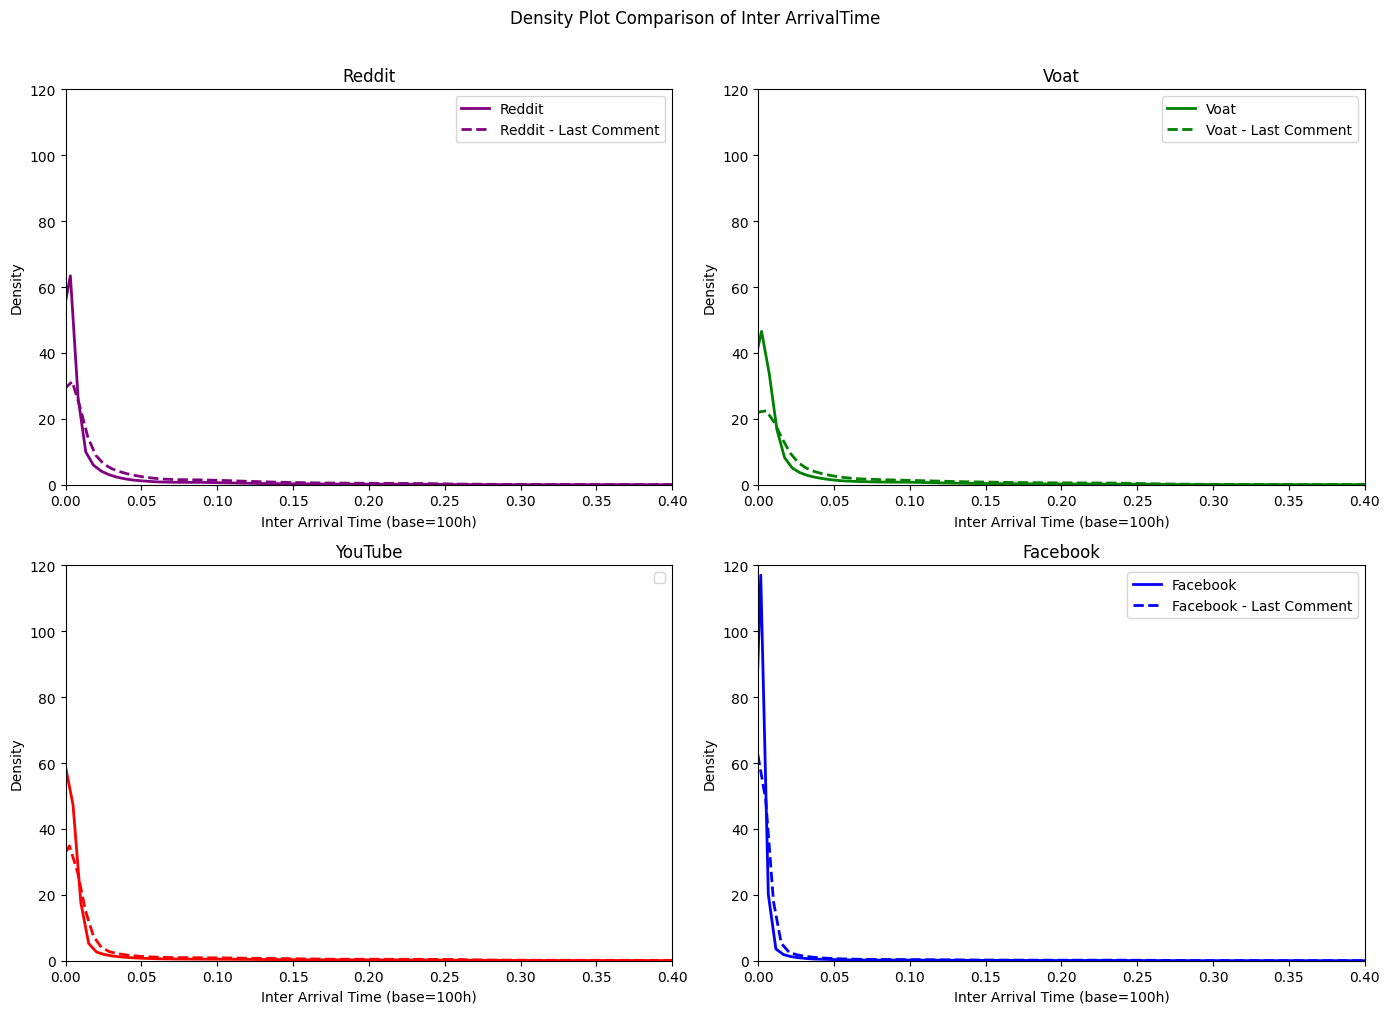

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data loaded correctly into DataFrames: IAT_fb, IAT_f_fb, IAT_rd, IAT_f_rd, IAT_yt, IAT_f_yt, IAT_vo, IAT_f_vo
# Each DataFrame has a column 'time_difference'

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Reddit
sns.kdeplot(data=IAT_rd['time_difference'], label='Reddit', color='purple', linewidth=2, ax=axes[0, 0])
sns.kdeplot(data=IAT_f_rd['time_difference'], label='Reddit - Last Comment', color='purple', linestyle='--', linewidth=2, ax=axes[0, 0])
axes[0, 0].set_xlim(0, 0.4)
axes[0, 0].set_ylim(0, 120)
axes[0, 0].set_title('Reddit')
axes[0, 0].legend()

# Voat
sns.kdeplot(data=IAT_vo['time_difference'], label='Voat', color='green', linewidth=2, ax=axes[0, 1])
sns.kdeplot(data=IAT_f_vo['time_difference'], label='Voat - Last Comment', color='green', linestyle='--', linewidth=2, ax=axes[0, 1])
axes[0, 1].set_xlim(0, 0.4)
axes[0, 1].set_ylim(0, 120)
axes[0, 1].set_title('Voat')
axes[0, 1].legend()

# Facebook
sns.kdeplot(data=IAT_fb['time_difference'], label='Facebook', color='blue', linewidth=2, ax=axes[1, 1])
sns.kdeplot(data=IAT_f_fb['time_difference'], label='Facebook - Last Comment', color='blue', linestyle='--', linewidth=2, ax=axes[1, 1])
axes[1, 0].set_xlim(0, 0.4)
axes[1, 0].set_ylim(0, 120)
axes[1, 1].set_title('Facebook')
axes[1, 0].legend()

# YouTube
sns.kdeplot(data=IAT_yt['time_difference'], label='YouTube', color='red', linewidth=2, ax=axes[1, 0])
sns.kdeplot(data=IAT_f_yt['time_difference'], label='YouTube - Last Comment', color='red', linestyle='--', linewidth=2, ax=axes[1,0])
axes[1, 1].set_xlim(0, 0.4)
axes[1, 1].set_ylim(0, 120)
axes[1, 0].set_title('YouTube')
axes[1, 1].legend()

# Customizing the appearance of the plots
for ax in axes.flat:
    ax.set_xlabel('Inter Arrival Time (base=100h)')
    ax.set_ylabel('Density')

plt.suptitle('Density Plot Comparison of Inter ArrivalTime', y=1.01)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data loaded correctly into DataFrames: merged_fb, merged_vo, merged_rd, merged_yt
# Each DataFrame has a column 'time_difference'

# Create a figure and axes
plt.figure(figsize=(10, 6))

# Adjust the positions for each boxplot
positions = [0,1, 2,3]  # Adjust these positions as needed

# Boxplot for merged_fb
sns.boxplot(x=positions[0], y='time_difference', data=merged_fb, color='blue', width=0.2,showfliers=False)

# Boxplot for merged_rd
sns.boxplot(x=positions[1], y='time_difference', data=merged_rd, color='orange', width=0.2,showfliers=False)

# Boxplot for merged_yt
sns.boxplot(x=positions[2], y='time_difference', data=merged_yt, color='red', width=0.2,showfliers=False)

# Boxplot for merged_yt
sns.boxplot(x=positions[3], y='time_difference', data=merged_vo, color='red', width=0.2,showfliers=False)

# Customizing the appearance of the plot
plt.title('Boxplot Comparison of time_difference for Different Datasets')
plt.xlabel('Datasets')
plt.ylabel('time_difference')
plt.xticks(positions, ['merged_fb', 'merged_rd', 'merged_yt', 'merged_vo'])  # Assign labels to positions
plt.grid(True)

# Show the plot
plt.show()

merged_fb['time_difference'].median()

merged_rd['time_difference'].median()

merged_yt['time_difference'].median()

merged_vo['time_difference'].median()



# Pipeline to estimate Parameters' dictionary

In [ ]:
from SYN_package.estimate_parameters import *
params_dict={}

In [ ]:
# Example usage:
names = ['vo', 'fb', 'rd', 'yt']
datas = [vo, fb, rd, yt]  # Assuming vo, fb, rd, yt are your actual dataframes

params_dict = process_social_platform(names, datas)
print(params_dict)

In [4]:
params_dict={'vo': {'gamma': 5.560174158235733,
  'a': 0.7683453768943135,
  'b': 181.35859916908146,
  'loc': 0.0009999999999999998,
  'scale': 10.849357267138616,
  'alpha': 0.35,
  'lambda': 0.5000000000000001,
  'c': 1.3825444184574849,
  'd': 0.3148667223304995,
  'l': -7.559994673910446e-07,
  's': 0.014817594985246601,
  'cf': 5.288800316735881,
  'df': 0.04913571005774435,
  'lf': 2.7777777777777775e-06,
  'sf': 0.24403022567064098},
 'fb': {'gamma': 1.920612852062878,
  'a': 0.3844295492882861,
  'b': 294.47288219865607,
  'loc': 0.0009999999999999998,
  'scale': 33.07578198818712,
  'alpha': 0.1,
  'lambda': 1.0500000000000003,
  'c': 1.4925263821442911,
  'd': 0.08849381153322906,
  'l': 2.7777777777777775e-06,
  's': 1.3440750553651393,
  'cf': 1.1530515610823424,
  'df': 0.1221286925154284,
  'lf': 2.7777777777777775e-06,
  'sf': 1.243471290490271},
 'rd': {'gamma': 2.1172386372477376,
  'a': 1.3208418726992361,
  'b': 366274394.2558266,
  'loc': 0.00043188573340450587,
  'scale': 21377429.04281839,
  'alpha': 0.3,
  'lambda': 0.5000000000000001,
  'c': 1.4035122312087873,
  'd': 0.34547543092801714,
  'l': 2.777777777776469e-06,
  's': 0.009685929534020282,
  'cf': 1.061267002974987,
  'df': 0.16381176822206486,
  'lf': 2.7777777777777775e-06,
  'sf': 1.708837260306469},
 'yt': {'gamma': 1.4925219530385783,
  'a': 0.5186615140672572,
  'b': 1.7898387515641103,
  'loc': 0.0009999999999999998,
  'scale': 1.1104373293304093,
  'alpha': 0.25,
  'lambda': 0.7000000000000002,
  'c': 0.23913021624295291,
  'd': 0.8360268077508817,
  'l': 2.7777777777777775e-06,
  's': 1.1670856167197128,
  'cf': 0.9540739202382167,
  'df': 0.16186901441564588,
  'lf': 2.7777777777777775e-06,
  'sf': 1.6193827108817946}}

In [ ]:
params_dict={'vo': {'gamma': 5.560174158235733,
  'a': 0.7683453768943135,
  'b': 181.35859916908146,
  'loc': 0.0009999999999999998,
  'scale': 10.849357267138616,
  'alpha': 0.35,
  'lambda': 0.5000000000000001,
  'c': 1.3825444184574849,
  'd': 0.3148667223304995,
  'l': -7.559994673910446e-07,
  's': 0.014817594985246601,
  'cf': 5.288800316735881,
  'df': 0.04913571005774435,
  'lf': 2.7777777777777775e-06,
  'sf': 0.24403022567064098},
 'fb': {'gamma': 1.920612852062878,
  'a': 0.3844295492882861,
  'b': 294.47288219865607,
  'loc': 0.0009999999999999998,
  'scale': 33.07578198818712,
  'alpha': 0.1,
  'lambda': 1.0500000000000003,
  'c': 1.4925263821442911,
  'd': 0.08849381153322906,
  'l': 2.7777777777777775e-06,
  's': 1.3440750553651393,
  'cf': 1.1530515610823424,
  'df': 0.1221286925154284,
  'lf': 2.7777777777777775e-06,
  'sf': 1.243471290490271},
 'rd': {'gamma': 2.1172386372477376,
  'a': 1.3208418726992361,
  'b': 366274394.2558266,
  'loc': 0.00043188573340450587,
  'scale': 21377429.04281839,
  'alpha': 0.3,
  'lambda': 0.5000000000000001,
  'c': 1.4035122312087873,
  'd': 0.34547543092801714,
  'l': 2.777777777776469e-06,
  's': 0.009685929534020282,
  'cf': 1.061267002974987,
  'df': 0.16381176822206486,
  'lf': 2.7777777777777775e-06,
  'sf': 1.708837260306469},
 'yt': {'gamma': 1.4925219530385783,
  'a': 0.5186615140672572,
  'b': 1.7898387515641103,
  'loc': 0.0009999999999999998,
  'scale': 1.1104373293304093,
  'alpha': 0.25,
  'lambda': 0.7000000000000002,
  'c': 0.23913021624295291,
  'd': 0.8360268077508817,
  'l': 2.7777777777777775e-06,
  's': 1.1670856167197128,
  'cf': 0.9540739202382167,
  'df': 0.16186901441564588,
  'lf': 2.7777777777777775e-06,
  'sf': 1.6193827108817946}}

## Manual Pipeline

In [ ]:
# Example usage:
names = ['vo', 'fb', 'rd', 'yt']
datas = [vo, fb, rd, yt]  # Assuming vo, fb, rd, yt are your actual dataframes

params_dict = process_social_platform(names, datas)
print(params_dict)

In [ ]:
names=['vo','fb','rd','yt']
datas=[vo,fb,rd,yt]

names=['vo']
datas=[vo]

for i,df in tqdm(enumerate(datas),total=len(names)):
  social=names[i]
  params_dict[social]={}
  params_dict[social]['gamma']=estimate_parameters_U(df)

  time = df[df['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
  time_params = fit_beta_distribution(time)
  params_dict[social]['a']=time_params['a']
  params_dict[social]['b']=time_params['b']
  params_dict[social]['loc']=time_params['loc']
  params_dict[social]['scale']=time_params['scale']

  size_of_interaction = df.groupby(['user_id', 'post_id'])['comment_id'].count().reset_index()
  observed_data =size_of_interaction['comment_id']-1
  alpha_range =  np.arange(0, 1, 0.05)
  lambda_range = np.arange(0.1, 2, 0.05)
  best_alpha = None
  best_lambda = None
  best_loss = np.inf
  for alpha in (alpha_range):
      for lambda_ in lambda_range:
          simulated_data = simulate_zip(alpha, lambda_, size=len(observed_data))
          max_value = max(np.max(observed_data), np.max(simulated_data))
          observed_counts = np.bincount(observed_data, minlength=max_value + 1)
          simulated_counts = np.bincount(simulated_data, minlength=max_value + 1)
          observed_distribution = observed_counts / np.sum(observed_counts)
          simulated_distribution = simulated_counts / np.sum(simulated_counts)
          loss = kl_divergence(observed_distribution, simulated_distribution)
          if loss < best_loss:
              best_loss = loss
              best_alpha = alpha
              best_lambda = lambda_

  params_dict[names[i]]['alpha']=np.round(best_alpha,3)
  params_dict[names[i]]['lambda']=best_lambda
  IAT,IAT_f = process_platform(df, social)

  data = IAT['time_difference']
  data = data[data > 0]
  params_dict[social]['c'],params_dict[social]['d'],params_dict[social]['l'],params_dict[social]['s'] = burr.fit(data)

  data = IAT_f['time_difference']
  data = data[data > 0]
  params_dict[social]['cf'],params_dict[social]['df'],params_dict[social]['lf'],params_dict[social]['sf'] = burr.fit(data)



{'fb': {'gamma': 1.920612852062878},
 'rd': {'gamma': 2.1172386372477376},
 'yt': {'gamma': 1.4925219530385783},
 'vo': {'gamma': 5.560174158235733,
  'a': 0.7683453768943135,
  'b': 181.35859916908146,
  'loc': 0.0009999999999999998,
  'scale': 10.849357267138616,
  'alpha': 0.35,
  'lambda': 0.45000000000000007,
  'c': 1.3825444184574849,
  'd': 0.3148667223304995,
  'l': -7.559994673910446e-07,
  's': 0.014817594985246601,
  'cf': 5.288800316735881,
  'df': 0.04913571005774435,
  'lf': 2.7777777777777775e-06,
  'sf': 0.24403022567064098}}

In [ ]:
lista_dei_social=[fbt,fbn]
nomi_dei_social=['fbt','fbn']
from scipy.stats import beta


# Example data fitting for each social media platform
params_dict = {}

# Example data fitting for YouTube (yt)
print('Starting fbt')
social=fbt
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
yt_params = fit_beta_distribution(data)
params_dict['fbt'] = yt_params

# Example data fitting for Facebook (fb)
print('Starting fbn')
social=fbn
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
fb_params = fit_beta_distribution(data)
params_dict['fbn'] = fb_params

# Example data fitting for Reddit (rd)
print('Starting rd')
social=rd
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
rd_params = fit_beta_distribution(data)
params_dict['rd'] = rd_params

# Example data fitting for Voat (vo)
print('Starting vo')
social=vo
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
vo_params = fit_beta_distribution(data)
params_dict['vo'] = vo_params

# Display the parameters
for social, params in params_dict.items():
    print(f"{social}:")
    print(f"  Shape parameter (a): {params['a']}")
    print(f"  Shape parameter (b): {params['b']}")
    print(f"  Location parameter: {params['loc']}")
    print(f"  Scale parameter: {params['scale']}")
    print()

params_dict = {}



# Stima il parametro gamma per ciascuna distribuzione
xmin_fb = 50  # Valore minimo noto
gamma_fb = fit_power_law(observed_fb, xmin_fb)
params_dict['fb']['gamma']=gamma_fb

xmin_rd = 50  # Valore minimo noto
gamma_rd = fit_power_law(observed_rd, xmin_rd)
params_dict['rd']['gamma']=gamma_rd

xmin_yt = 50  # Valore minimo noto
gamma_yt = fit_power_law(observed_yt, xmin_yt)
params_dict['yt']['gamma']=gamma_yt

xmin_vo = 50  # Valore minimo noto
gamma_vo = fit_power_law(observed_vo, xmin_vo)
params_dict['vo']['gamma']=gamma_vo


# Produce synthetic data

In [13]:
names = ['vo', 'fb', 'rd', 'yt']
datas = [vo, fb, rd, yt]  # Assuming vo, fb, rd, yt are your actual dataframes
time_intervals = np.arange(0, 1, 0.01)
all_dfs=[]
for i,df in  tqdm(enumerate(datas),total=len(datas)):
    social=names[i]
    parameters=params_dict[social]
    # Simulazione dei dati per la piattaforma corrente
    n = 100
    simulated_t, observed_t = simulate_data(df, parameters['gamma'], parameters['a'], parameters['b'], parameters['loc'],
                                            parameters['scale'], parameters['alpha'], parameters['lambda'], parameters['c'],
                                            parameters['d'], parameters['l'], parameters['s'], parameters['cf'],
                                            parameters['df'], parameters['lf'], parameters['sf'], num_threads=n,activate_tqdm=False)
    globals()[social+'s'] = simulated_t
    globals()[social+'o'] = observed_t
    continue


    # Calcolo dell'ECDF per i dati simulati e osservati
    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    # Concatenazione dei dataframe per simulati e osservati per la piattaforma corrente
    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

# Concatenazione di tutti i dataframe delle piattaforme
df_all = pd.concat(all_dfs, ignore_index=True)

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', ci=99)
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

 75%|███████▌  | 3/4 [04:24<01:28, 88.13s/it]


KeyboardInterrupt: 

### Test Lifetime  comparison

Is the model simulating even  this?

<ipython-input-19-eee4472c4f2a>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'blue'])


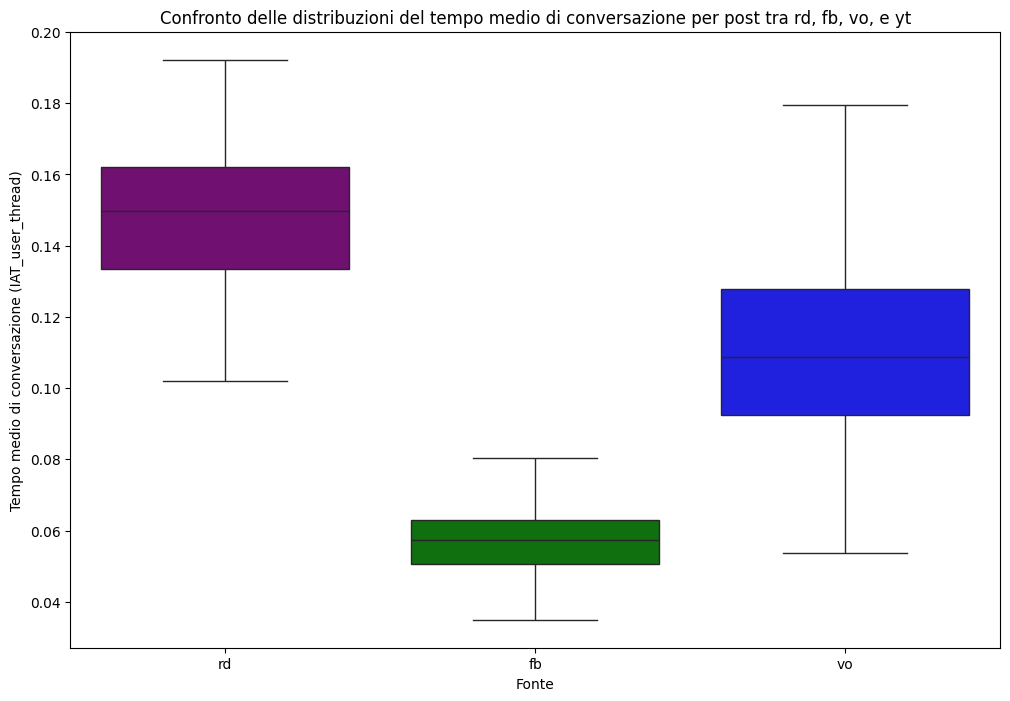

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rds=rds.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
fbs=fbs.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
vos=vos.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()


# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_rd = rds.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_rd = time_of_conversation_rd.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in fb
time_of_conversation_fb = fbs.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in fb
mean_time_of_conversation_fb = time_of_conversation_fb.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in vo
time_of_conversation_vo = vos.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in vo
mean_time_of_conversation_vo = time_of_conversation_vo.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()


# Unire i dati per fare il confronto
mean_time_of_conversation_rd['source'] = 'rd'
mean_time_of_conversation_fb['source'] = 'fb'
mean_time_of_conversation_vo['source'] = 'vo'

combined_data = pd.concat([
    mean_time_of_conversation_rd,
    mean_time_of_conversation_fb,
    mean_time_of_conversation_vo
])

# Creare i boxplot per confrontare le distribuzioni
plt.figure(figsize=(12, 8))
sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'blue'])
plt.title('Confronto delle distribuzioni del tempo medio di conversazione per post tra rd, fb, vo, e yt')
plt.xlabel('Fonte')
plt.ylabel('Tempo medio di conversazione (IAT_user_thread)')
plt.show()


<ipython-input-20-2362441461c4>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'blue'])


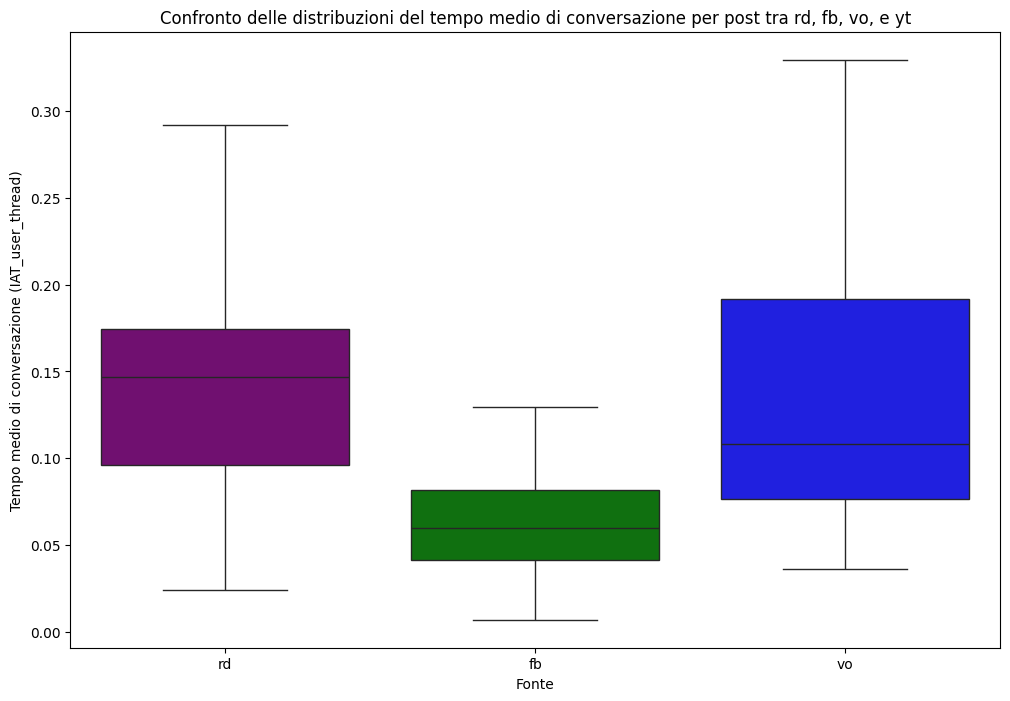

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rdo=rdo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
fbo=fbo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
voo=voo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()


# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_rd = rdo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_rd = time_of_conversation_rd.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in fb
time_of_conversation_fb = fbo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in fb
mean_time_of_conversation_fb = time_of_conversation_fb.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in vo
time_of_conversation_vo = voo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in vo
mean_time_of_conversation_vo = time_of_conversation_vo.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()


# Unire i dati per fare il confronto
mean_time_of_conversation_rd['source'] = 'rd'
mean_time_of_conversation_fb['source'] = 'fb'
mean_time_of_conversation_vo['source'] = 'vo'

combined_data = pd.concat([
    mean_time_of_conversation_rd,
    mean_time_of_conversation_fb,
    mean_time_of_conversation_vo
])

# Creare i boxplot per confrontare le distribuzioni
plt.figure(figsize=(12, 8))
sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'blue'])
plt.title('Confronto delle distribuzioni del tempo medio di conversazione per post tra rd, fb, vo, e yt')
plt.xlabel('Fonte')
plt.ylabel('Tempo medio di conversazione (IAT_user_thread)')
plt.show()


In [ ]:
import random
names = ['vo', 'fb', 'rd', 'yt']
datas = [vo, fb, rd, yt]  # Assuming vo, fb, rd, yt are your actual dataframes
time_intervals = np.arange(0, 1, 0.01)
all_dfs=[]
for i,df in  (enumerate(datas)):#,total=len(datas))
    social=names[i]
    parameters=params_dict[social]
    # Simulazione dei dati per la piattaforma corrente
    n = 100
    simulated_t, observed_t = simulate_data(df, parameters['gamma'], parameters['a'], parameters['b'], parameters['loc'],
                                            parameters['scale'], parameters['alpha'], parameters['lambda'], parameters['c'],
                                            parameters['d'], parameters['l'], parameters['s'], parameters['cf'],
                                            parameters['df'], parameters['lf'], parameters['sf'], num_threads=n,activate_tqdm=False)

    # Calcolo dell'ECDF per i dati simulati e osservati
    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    # Concatenazione dei dataframe per simulati e osservati per la piattaforma corrente
    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

# Concatenazione di tutti i dataframe delle piattaforme
df_all = pd.concat(all_dfs, ignore_index=True)

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', ci=99)
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

<module 'random' from '/usr/lib/python3.10/random.py'>

## Fai un test di Kolmogorov Smirnov

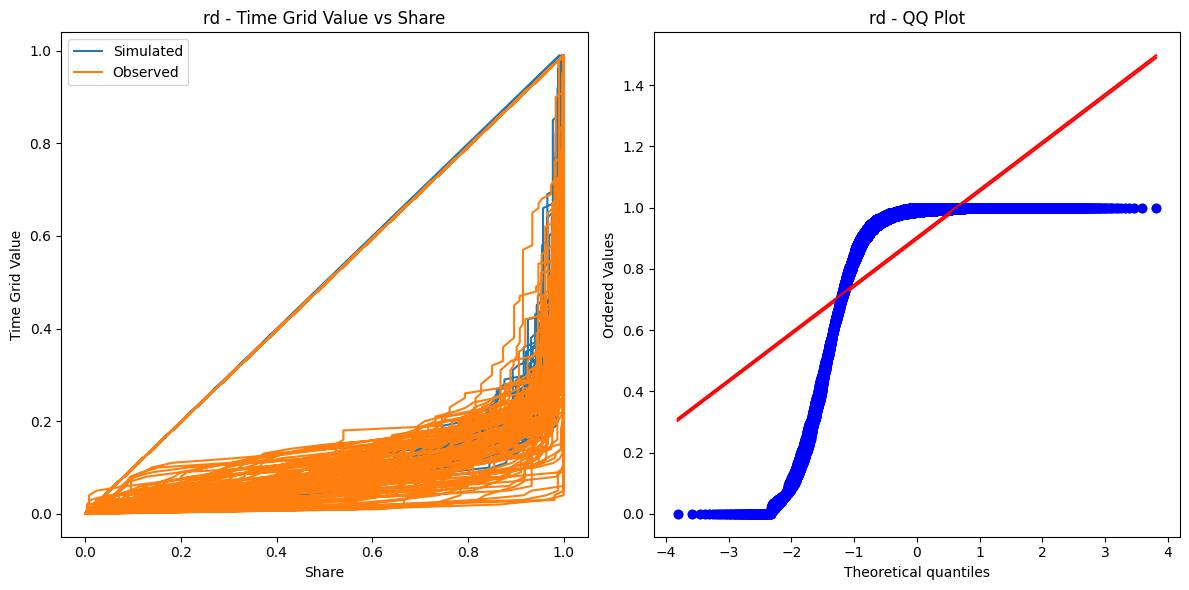

R^2: 0.857979213092029
KS Statistic: 0.335, p-value: 0.0


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, probplot
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming df_all is the DataFrame loaded with the data
# Example extraction provided:
# vo_s = df_all[(df_all['Platform']=='vo') & (df_all['Style']=='Simulated')][['Share','Time Grid Value']]
# vo_o = df_all[(df_all['Platform']=='vo') & (df_all['Style']=='Observed')][['Share','Time Grid Value']]

# Let's define a function to perform the analysis
def analyze_distributions(df, platform):
    simulated = df[(df['Platform'] == platform) & (df['Style'] == 'Simulated')][['Share', 'Time Grid Value']]
    observed = df[(df['Platform'] == platform) & (df['Style'] == 'Observed')][['Share', 'Time Grid Value']]

    # Reshape data for comparison
    sim_values = simulated['Share'].values
    obs_values = observed['Share'].values

    # Calculate R^2
    r2 = r2_score(obs_values, sim_values)

    # Perform KS test
    ks_stat, ks_p_value = ks_2samp(obs_values, sim_values)

    # Generate QQ plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(sim_values,simulated['Time Grid Value'], label='Simulated')
    plt.plot(obs_values,observed['Time Grid Value'], label='Observed')
    plt.xlabel('Share')
    plt.ylabel('Time Grid Value')
    plt.title(f'{platform} - Time Grid Value vs Share')
    plt.legend()

    plt.subplot(1, 2, 2)
    probplot(simulated['Share'], dist="norm", plot=plt)
    probplot(observed['Share'], dist="norm", plot=plt)
    plt.title(f'{platform} - QQ Plot')

    plt.tight_layout()
    plt.show()

    return r2, ks_stat, ks_p_value

# Example of using the function for 'vo' platform
r2, ks_stat, ks_p_value = analyze_distributions(df_all, 'rd')
print(f'R^2: {r2}')
print(f'KS Statistic: {ks_stat}, p-value: {ks_p_value}')


In [ ]:
time_intervals = np.arange(0, 1, 0.01)  # Utilizzo di np.arange per intervalli decimali

simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
simulated_t_ECDF['Platform']='Toxic'
simulated_t_ECDF['Style']='Simulated'
observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
observed_t_ECDF['Platform']='Toxic'
observed_t_ECDF['Style']='Observed'

Processing DataFrame: 100%|██████████| 500/500 [00:55<00:00,  9.00it/s]


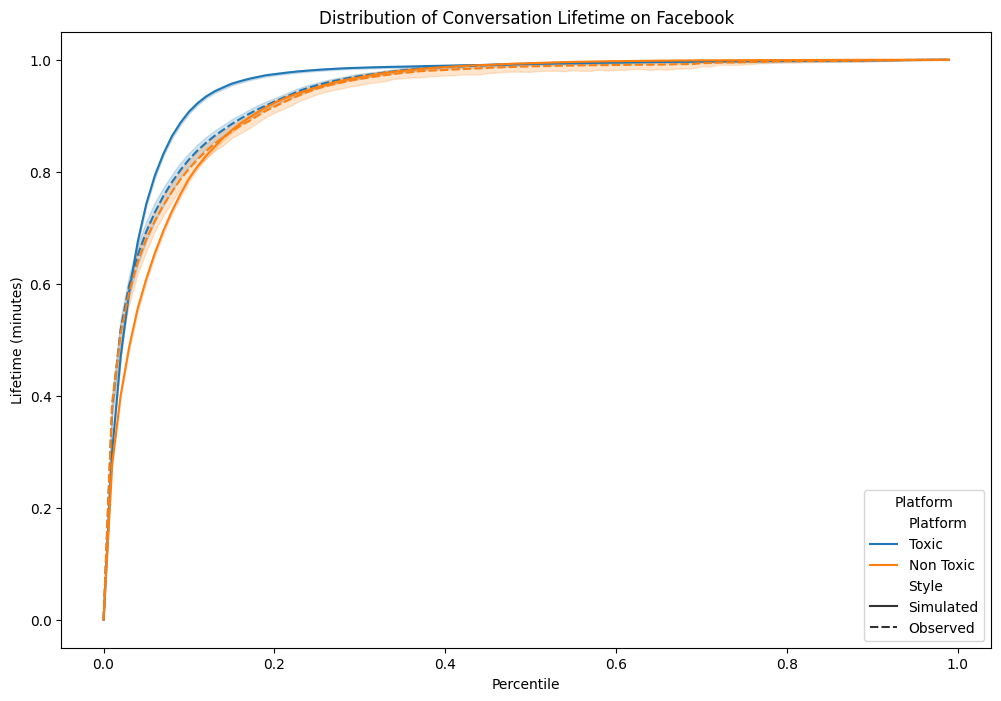

In [ ]:
df = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
# Plotting lineplot for both Reddit and Facebook with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Time Grid Value', y='Share',hue='Platform',style='Style', errorbar=('ci', 99))
#sns.lineplot(data=df, x='Time Grid Value', y='Share_cc',hue='Platform', errorbar=('ci', 99))
plt.title('Distribution of Conversation Lifetime on Facebook')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()
# con a,b uguale a 0.8,20

### Parameters FB

In [ ]:
n=10
parameters=params_dict['fb']
gamma=parameters['gamma']
a=parameters['a']
b= parameters['b']
loc=parameters['loc']
scale=parameters['scale']

alpha=parameters['alpha']
lambda_=parameters['lambda']

c=parameters['c']
d=parameters['d']
l=parameters['l']
s=parameters['s']

cf=parameters['cf']
df=parameters['df']
lf=parameters['lf']
sf=parameters['sf']

simulated, observed=simulate_data(fb,gamma, a, b,loc,scale, alpha, lambda_,c,d,l,s,cf,df,lf,sf,num_threads=n)

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


KeyError: "['temporal_distance_birth_base_100h'] not in index"

In [ ]:
time_intervals = np.arange(0, 1, 0.01)  # Utilizzo di np.arange per intervalli decimali

simulated_ECDF = calculate_ECDF(simulated, time_intervals)
simulated_ECDF['Platform']='Simulated'
observed_ECDF = calculate_ECDF(observed, time_intervals)
observed_ECDF['Platform']='Observed'

Processing DataFrame: 100%|██████████| 1000/1000 [01:50<00:00,  9.02it/s]


In [ ]:
combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)
error = calculate_loss(simulated_ECDF, observed_ECDF)
print('The error is equal to: ' + str(round(error, 2)))
print(len(simulated)/len( observed))

The error is equal to: 15999.38
1.578953451414372


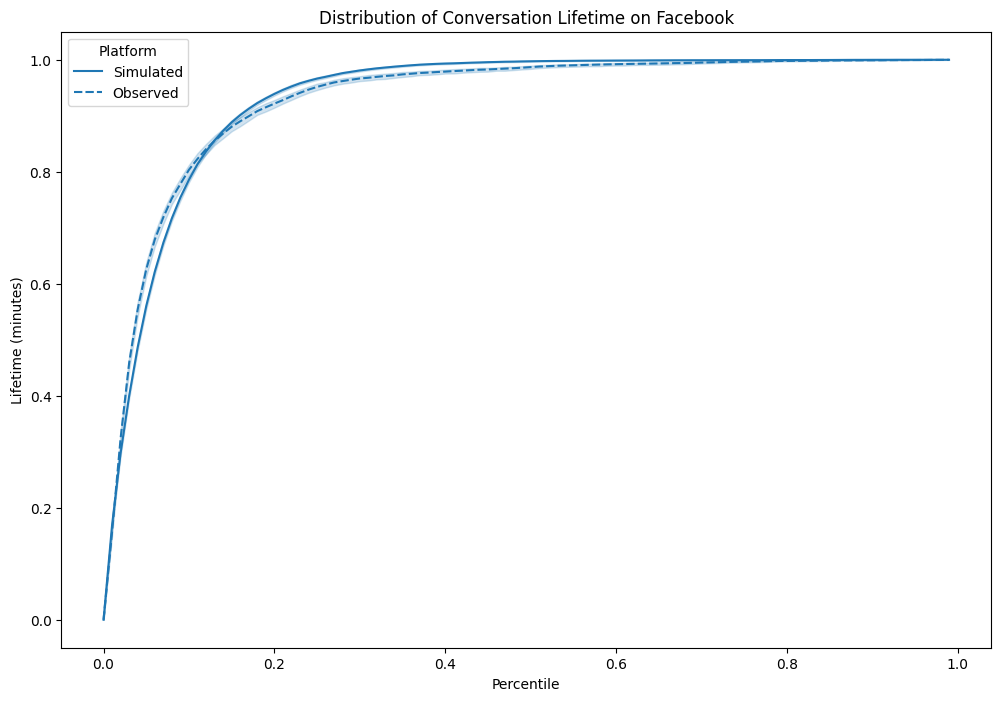

In [ ]:
df = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)
# Plotting lineplot for both Reddit and Facebook with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Time Grid Value', y='Share',style='Platform', errorbar=('ci', 99))
#sns.lineplot(data=df, x='Time Grid Value', y='Share_cc',hue='Platform', errorbar=('ci', 99))
plt.title('Distribution of Conversation Lifetime on Facebook')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()
# con a,b uguale a 0.8,20

### Parameters YT

In [ ]:
n=100
parameters=params_dict['yt']

a=parameters['a']
b= parameters['b']
loc=parameters['loc']
scale=parameters['scale']

alpha=parameters['alpha']
lambda_=parameters['lambda']

c=parameters['c']
d=parameters['d']
l=parameters['l']
s=parameters['s']

cf=parameters['cf']
df=parameters['df']
lf=parameters['lf']
sf=parameters['sf']

simulated, observed=simulate_data(yt, a, b,loc,scale, alpha, lambda_,c,d,l,s,cf,df,lf,sf,num_threads=n)

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


In [ ]:
simulated_ECDF = calculate_ECDF(simulated, time_intervals)
simulated_ECDF['Platform']='Simulated'
observed_ECDF = calculate_ECDF(observed, time_intervals)
observed_ECDF['Platform']='observed'

combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)


Processing DataFrame: 100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


In [ ]:
error = calculate_loss(simulated_ECDF, observed_ECDF)
print('The error is equal to: ' + str(round(error, 2)))
print(len(simulated)/len( observed))

The error is equal to: 2404.06
0.8601959311328131


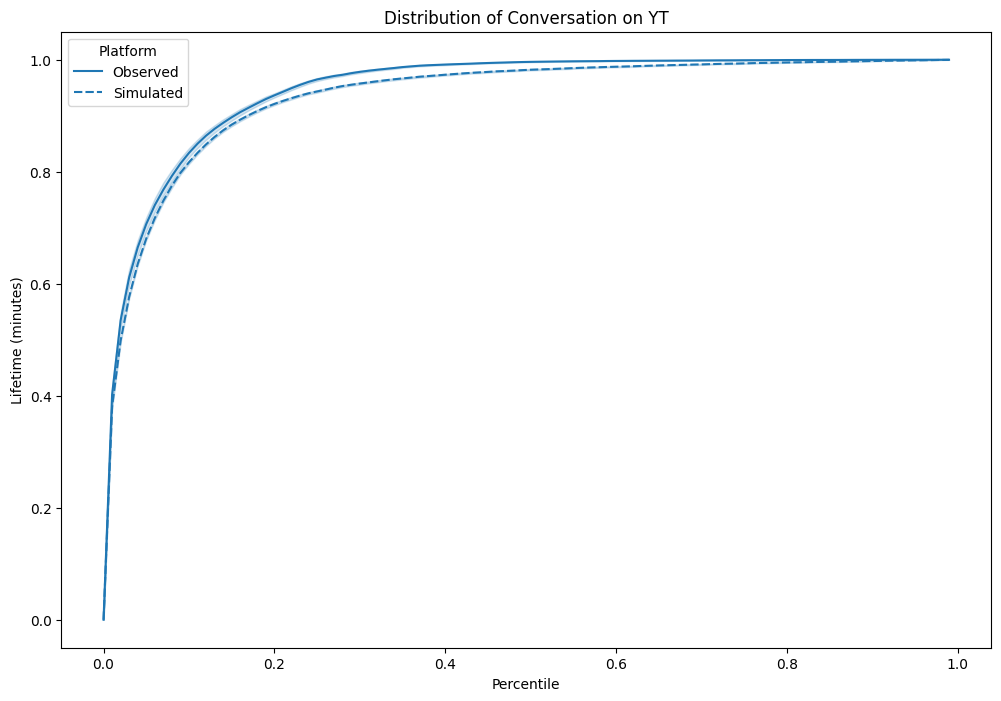

In [ ]:

# Concatenate all ECDF data into one DataFrame
combined_results = pd.concat([ observed_ECDF, simulated_ECDF], ignore_index=True)
combined_results['Style']=combined_results['Platform']
# Plotting lineplot for all platforms with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=combined_results, x='Time Grid Value', y='Share',errorbar=('ci', 99), style='Style')
#sns.lineplot(data=combined_results, x='Time Grid Value', y='Share_cc', hue='Platform',errorbar=('ci', 99), style='Style')
plt.title('Distribution of Conversation on YT')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

### Parameters Vo

In [ ]:
n=100
parameters=params_dict['vo']

a=parameters['a']
b= parameters['b']
loc=parameters['loc']
scale=parameters['scale']

alpha=parameters['alpha']
lambda_=parameters['lambda']

c=parameters['c']
d=parameters['d']
l=parameters['l']
s=parameters['s']

cf=parameters['cf']
df=parameters['df']
lf=parameters['lf']
sf=parameters['sf']

simulated, observed=simulate_data(vo, a, b,loc,scale, alpha, lambda_,c,d,l,s,cf,df,lf,sf)

100%|██████████| 100/100 [00:01<00:00, 75.74it/s]


In [ ]:
simulated_ECDF = calculate_ECDF(simulated, time_intervals)
simulated_ECDF['Platform']='Simulated'
observed_ECDF = calculate_ECDF(observed, time_intervals)
observed_ECDF['Platform']='Voat'

combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)


Processing DataFrame: 100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


In [ ]:
error = calculate_loss(simulated_ECDF, observed_ECDF)
print('The error is equal to: ' + str(round(error, 2)))
print(len(simulated)/len( observed))

The error is equal to: 1651.42
1.0593175153292456


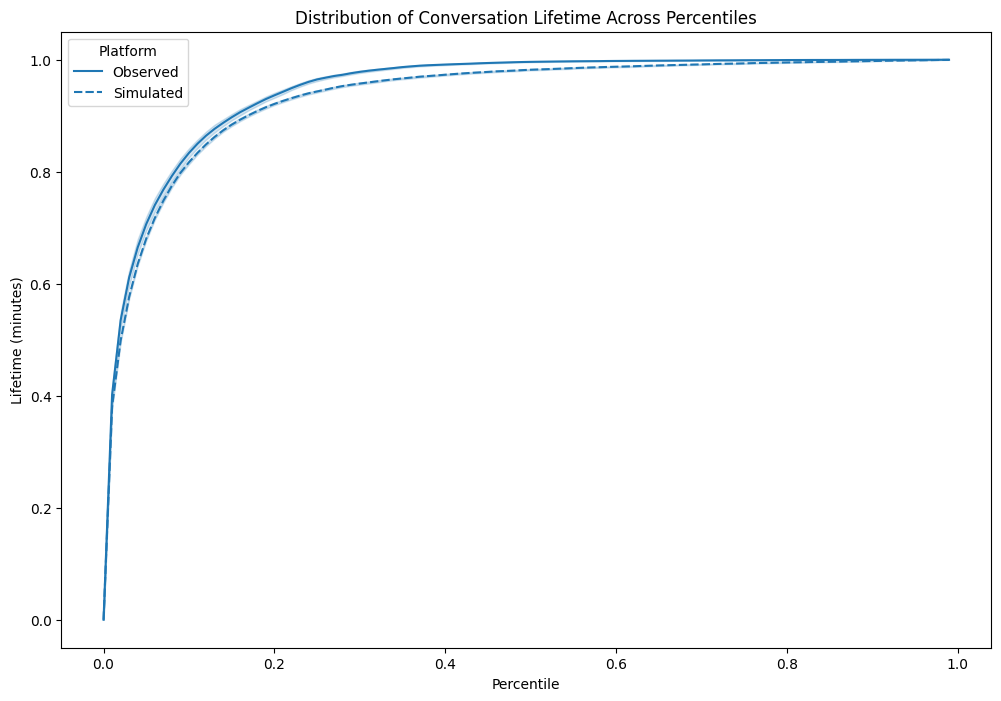

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming observed_ECDF and simulated_ECDF are already defined DataFrames

# Concatenate the ECDF data into one DataFrame
combined_results = pd.concat([observed_ECDF, simulated_ECDF], ignore_index=True)

# Plotting lineplot for all platforms with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=combined_results, x='Time Grid Value', y='Share', style='Platform', errorbar=('ci', 99))
#sns.lineplot(data=combined_results, x='Time Grid Value', y='Share_cc', hue='Platform', errorbar=('ci', 99))

plt.title('Distribution of Conversation on Voat')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')



plt.show()

### Parameters RD

In [ ]:
n=100
parameters=params_dict['rd']

a=parameters['a']
b= parameters['b']
loc=parameters['loc']
scale=parameters['scale']

alpha=parameters['alpha']
lambda_=parameters['lambda']

c=parameters['c']
d=parameters['d']
l=parameters['l']
s=parameters['s']

cf=parameters['cf']
df=parameters['df']
lf=parameters['lf']
sf=parameters['sf']

simulated, observed=simulate_data(rd, a, b,loc,scale, alpha, lambda_,c,d,l,s,cf,df,lf,sf)

100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


In [ ]:
simulated_ECDF = calculate_ECDF(simulated, time_intervals)
simulated_ECDF['Platform']='Simulated'
observed_ECDF = calculate_ECDF(observed, time_intervals)
observed_ECDF['Platform']='Reddit'

combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)


Processing DataFrame: 100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


In [ ]:
error = calculate_loss(simulated_ECDF, observed_ECDF)
print('The error is equal to: ' + str(round(error, 2)))
print(len(simulated)/len( observed))

The error is equal to: 1851.9
1.1484446617368453


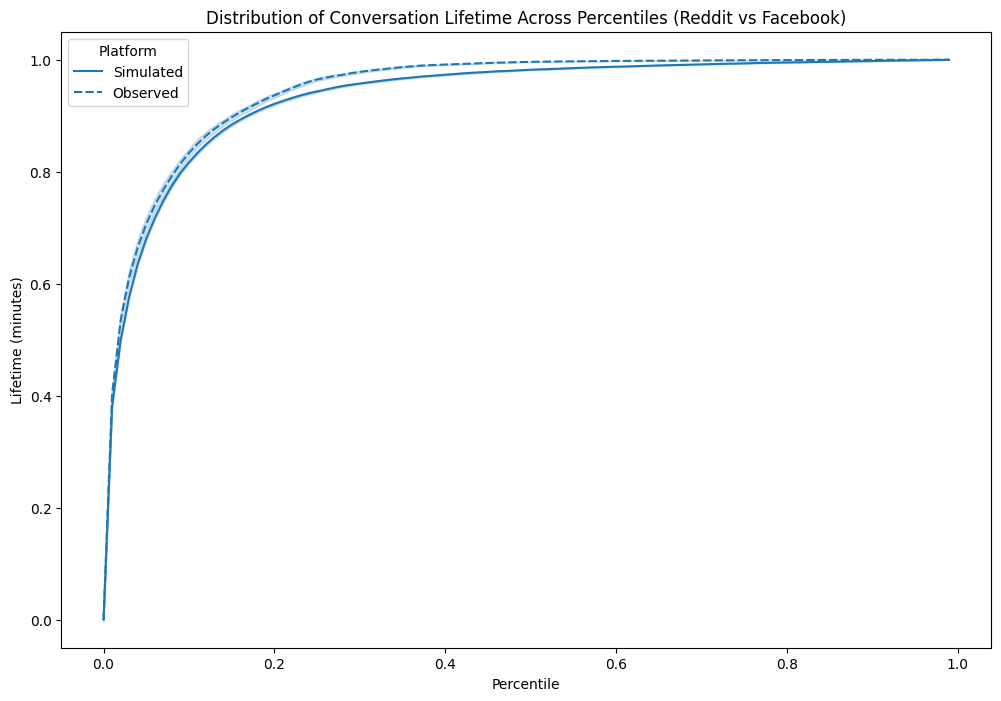

In [ ]:
combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)
df=combined_results
# Plotting lineplot for both Reddit and Facebook with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Time Grid Value', y='Share',style='Platform', errorbar=('ci', 99))
#sns.lineplot(data=combined_results, x='Time Grid Value', y='Share_cc', hue='Platform', errorbar=('ci', 99))
plt.title('Distribution of Conversation Lifetime Across Percentiles (Reddit vs Facebook)')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()


## Global comparison

In [ ]:
social_platforms = [fb[fb['sequential_number_of_comment_by_user_in_thread']!=1], rd[rd['sequential_number_of_comment_by_user_in_thread']!=1], yt[yt['sequential_number_of_comment_by_user_in_thread']!=1], vo[vo['sequential_number_of_comment_by_user_in_thread']!=1]]
n = 100

# Assuming `params_dict` contains the parameters for each social platform
for i,social in enumerate(social_platforms):
    parameters = params_dict[nomi_dei_social[i]]

    a = parameters['a']
    b = parameters['b']
    loc = parameters['loc']
    scale = parameters['scale']

    alpha = parameters['alpha']
    lambda_ = parameters['lambda']

    c = parameters['c']
    d = parameters['d']
    l = parameters['l']
    s = parameters['s']

    cf = parameters['cf']
    df = parameters['df']
    lf = parameters['lf']
    sf = parameters['sf']

    simulated, observed = simulate_data(social, a, b, loc, scale, alpha, lambda_, c, d, l, s, cf, df, lf, sf)

    # Dynamically assign the simulated and observed data to variables
    globals()[f'simulated_{nomi_dei_social[i]}'] = simulated
    globals()[f'observed_{nomi_dei_social[i]}'] = observed


100%|██████████| 100/100 [00:00<00:00, 426.68it/s]


In [ ]:
simulated_fb_ECDF = calculate_ECDF(simulated_fb, time_intervals)
simulated_fb_ECDF['Platform']='Facebook'
simulated_fb_ECDF['Type']='Simulated'
observed_fb_ECDF = calculate_ECDF(observed_fb, time_intervals)
observed_fb_ECDF['Platform']='Facebook'
observed_fb_ECDF['Type']='Observed'

simulated_yt_ECDF = calculate_ECDF(simulated_yt, time_intervals)
simulated_yt_ECDF['Platform']='YouTube'
simulated_yt_ECDF['Type']='Simulated'
observed_yt_ECDF = calculate_ECDF(observed_yt, time_intervals)
observed_yt_ECDF['Platform']='YouTube'
observed_yt_ECDF['Type']='Observed'

simulated_rd_ECDF = calculate_ECDF(simulated_rd, time_intervals)
simulated_rd_ECDF['Platform']='Reddit'
simulated_rd_ECDF['Type']='Simulated'
observed_rd_ECDF = calculate_ECDF(observed_rd, time_intervals)
observed_rd_ECDF['Platform']='Reddit'
observed_rd_ECDF['Type']='Observed'

simulated_vo_ECDF = calculate_ECDF(simulated_vo, time_intervals)
simulated_vo_ECDF['Platform']='Voat'
simulated_vo_ECDF['Type']='Simulated'
observed_vo_ECDF = calculate_ECDF(observed_vo, time_intervals)
observed_vo_ECDF['Platform']='Voat'
observed_vo_ECDF['Type']='Observed'


combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF,simulated_yt_ECDF,observed_yt_ECDF,simulated_rd_ECDF,observed_rd_ECDF,simulated_vo_ECDF,observed_vo_ECDF], ignore_index=True)


,user_id,post_id,temporal_distance_birth_base_100h,sequential_number_of_comment_by_user_in_thread
0,User_0,--AMX2o_Icc,0.314982,1
1,User_0,--AMX2o_Icc,0.001004,1
2,User_0,--AMX2o_Icc,0.134569,1
3,User_1,--AMX2o_Icc,0.134572,2
4,User_2,--AMX2o_Icc,0.198060,3
...,...,...,...,...
10647,User_0,06kpSSSfx6Y,0.020846,1
10648,User_0,06kpSSSfx6Y,0.254965,1
10649,User_0,06kpSSSfx6Y,0.508466,1
10650,User_0,06kpSSSfx6Y,0.337692,1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF, simulated_rd_ECDF, observed_rd_ECDF], ignore_index=True)
combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF,simulated_yt_ECDF,observed_yt_ECDF,simulated_rd_ECDF,observed_rd_ECDF,simulated_vo_ECDF,observed_vo_ECDF], ignore_index=True)
#combined_results = pd.concat([ observed_fb_ECDF,observed_yt_ECDF,observed_rd_ECDF,observed_vo_ECDF], ignore_index=True)

df = combined_results
plt.figure(figsize=(12, 8))


line1 = sns.lineplot(data=df, x='Time Grid Value', y='Share', style='Type', hue='Platform', errorbar=('ci', 99))
#line2 = sns.lineplot(data=df, x='Time Grid Value', y='Share_cc', style='Type', hue='Platform', errorbar=('ci', 99))


handles1, labels1 = line1.get_legend_handles_labels()
handles2, labels2 = line2.get_legend_handles_labels()

handles, labels = [], []
for handle, label in zip(handles1 + handles2, labels1 + labels2):
    if label not in labels:
        handles.append(handle)
        labels.append(label)

plt.title('Distribution of Conversation Lifetime Across Percentiles (Reddit vs Facebook)')
plt.ylabel('Cumulative frequency of comments')
plt.xlabel('Time (base 100h)')
plt.grid(False)
plt.legend(handles=handles, labels=labels, title='Platform and Type')
plt.show()


NameError: name 'simulated_fb_ECDF' is not defined

#### Just observed

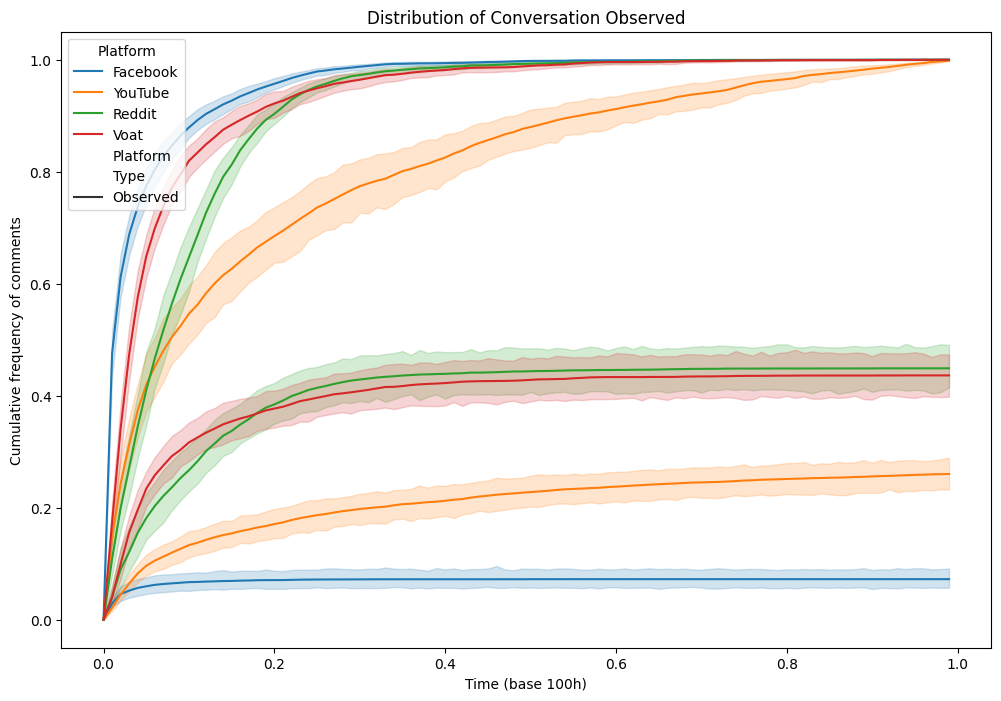

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF, simulated_rd_ECDF, observed_rd_ECDF], ignore_index=True)
combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF,simulated_yt_ECDF,observed_yt_ECDF,simulated_rd_ECDF,observed_rd_ECDF,simulated_vo_ECDF,observed_vo_ECDF], ignore_index=True)

df = combined_results
plt.figure(figsize=(12, 8))

df=df[df['Type']=='Observed']
line1 = sns.lineplot(data=df, x='Time Grid Value', y='Share', hue='Platform', errorbar=('ci', 99))
line2 = sns.lineplot(data=df, x='Time Grid Value', y='Share_cc', style='Type', hue='Platform', errorbar=('ci', 99))


handles1, labels1 = line1.get_legend_handles_labels()


handles, labels = [], []
for handle, label in zip(handles1 , labels1 ):
    if label not in labels:
        handles.append(handle)
        labels.append(label)

plt.title('Distribution of Conversation Observed')
plt.ylabel('Cumulative frequency of comments')
plt.xlabel('Time (base 100h)')
plt.grid(False)
plt.legend(handles=handles, labels=labels, title='Platform')
plt.show()


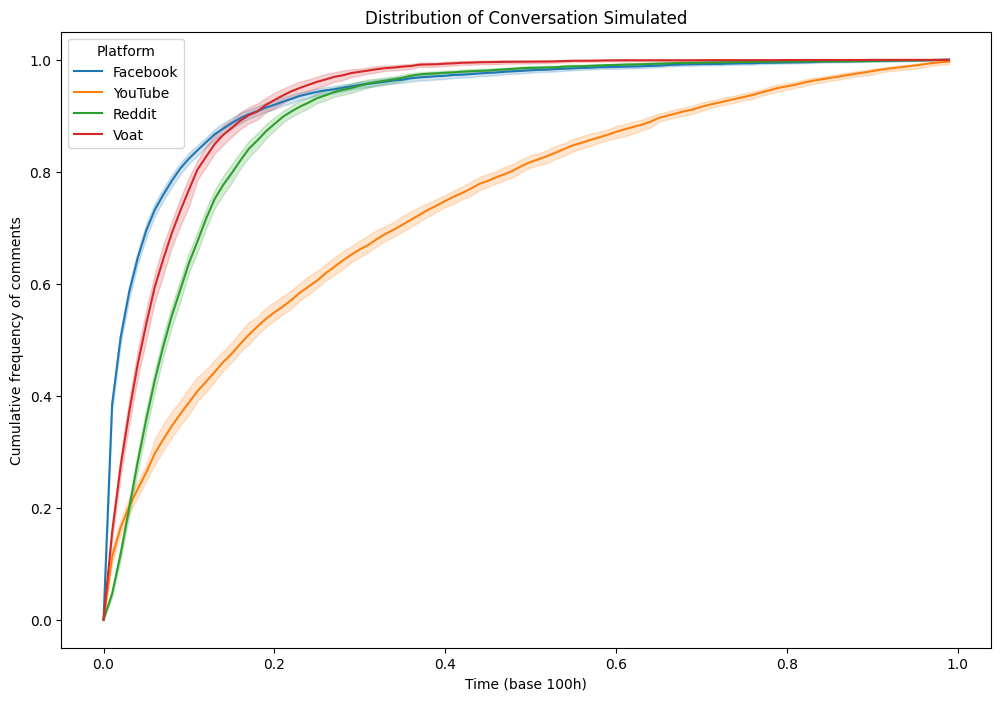

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF, simulated_rd_ECDF, observed_rd_ECDF], ignore_index=True)
combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF,simulated_yt_ECDF,observed_yt_ECDF,simulated_rd_ECDF,observed_rd_ECDF,simulated_vo_ECDF,observed_vo_ECDF], ignore_index=True)

df = combined_results
plt.figure(figsize=(12, 8))

df=df[df['Type']=='Simulated']
line1 = sns.lineplot(data=df, x='Time Grid Value', y='Share', hue='Platform', errorbar=('ci', 99))
#line2 = sns.lineplot(data=df, x='Time Grid Value', y='Share_cc', style='Type', hue='Platform', errorbar=('ci', 99))


handles1, labels1 = line1.get_legend_handles_labels()


handles, labels = [], []
for handle, label in zip(handles1 , labels1 ):
    if label not in labels:
        handles.append(handle)
        labels.append(label)

plt.title('Distribution of Conversation Simulated')
plt.ylabel('Cumulative frequency of comments')
plt.xlabel('Time (base 100h)')
plt.grid(False)
plt.legend(handles=handles, labels=labels, title='Platform')
plt.show()



## Analysis of parameters

#### T0

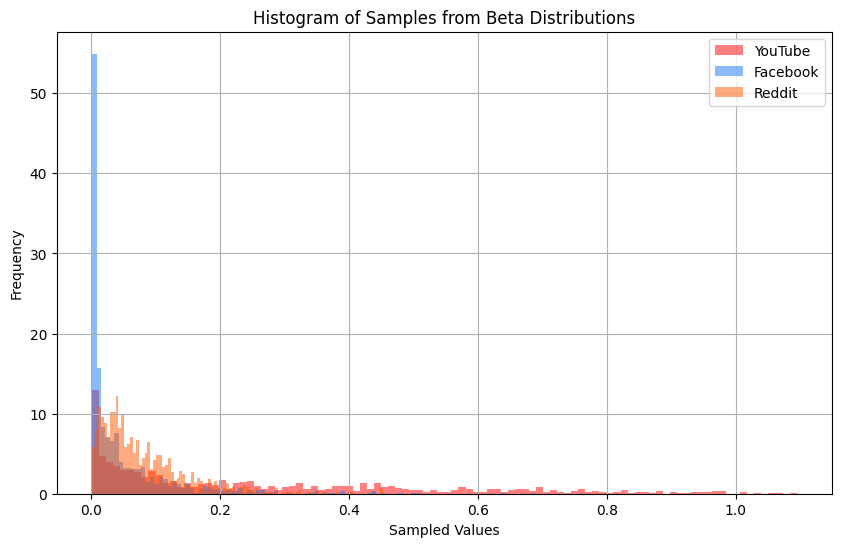

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Number of samples to draw from each distribution
num_samples = 1000

# Sample from each beta distribution
samples_yt = beta.rvs(params_dict['yt']['a'], params_dict['yt']['b'], loc=params_dict['yt']['loc'], scale=params_dict['yt']['scale'], size=num_samples)
samples_fb = beta.rvs(params_dict['fb']['a'], params_dict['fb']['b'], loc=params_dict['fb']['loc'], scale=params_dict['fb']['scale'], size=num_samples)
samples_vo = beta.rvs(params_dict['vo']['a'], params_dict['vo']['b'], loc=params_dict['vo']['loc'], scale=params_dict['vo']['scale'], size=num_samples)
samples_rd = beta.rvs(params_dict['rd']['a'], params_dict['rd']['b'], loc=params_dict['rd']['loc'], scale=params_dict['rd']['scale'], size=num_samples)

# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(samples_yt, bins=100, alpha=0.5, color='#FF0000', label='YouTube',density=True)   # Red for YouTube
plt.hist(samples_fb, bins=100, alpha=0.5, color='#1877F2', label='Facebook',density=True) # Facebook blue
#plt.hist(samples_vo, bins=100, alpha=0.5, color='grey', label='Voat',density=True)         # Grey for Voat
plt.hist(samples_rd, bins=100, alpha=0.5, color='#FF5700', label='Reddit',density=True)   # Orange for Reddit

plt.xlabel('Sampled Values')
plt.ylabel('Frequency')
plt.title('Histogram of Samples from Beta Distributions')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Grid Search

In [ ]:
import itertools
import pandas as pd

# Definisci i parametri per ciascuna piattaforma
facebook_params = [0.5, 11, 0.98, 4, 0.1, 0.005, 1.01]
reddit_params = [0.9, 13, 0.85, 5, 0.013, 0.01, 1.22]
youtube_params = [0.95, 12, 0.9, 4, 0.14, 0.03, 1.5]

# Metti insieme tutti i parametri
all_params = [facebook_params, reddit_params, youtube_params]


# Initialize an empty list to store results
results = []

# Time intervals (placeholder, da definire)
time_intervals = np.arange(0, 1, 0.01)  # Utilizzo di np.arange per intervalli decimali


# Loop over each parameter combination
for params in all_params:
    # Unpack the parameters
    a, b, alpha, lambda_, mu, sd, k = params

    # Simulate synthetic data
    simulated, observed = simulate_data(fb, alpha, lambda_, mu, sd, a, b, k, num_threads=100)

    # Calculate ECDFs
    simulated_ECDF = calculate_ECDF(simulated, time_intervals)
    simulated_ECDF['Platform'] = 'Simulated'
    observed_ECDF = calculate_ECDF(observed, time_intervals)
    observed_ECDF['Platform'] = 'Observed'

    # Calculate error
    error = calculate_loss(simulated_ECDF, observed_ECDF)

    # Append results tuple to list
    results.append((*params, error))

# Convert results list to DataFrame
results_df = pd.DataFrame(results, columns=['a', 'b', 'alpha', 'lambda_', 'mu', 'sd', 'k', 'Error'])

print(results_df)


,a,b,alpha,lambda_,mu,sd,k,Error
0,0.50,11,0.98,4,0.100,0.005,1.01,319.061252
1,0.90,13,0.85,5,0.013,0.010,1.22,539.726110
2,0.95,12,0.90,4,0.140,0.030,1.50,1424.112921


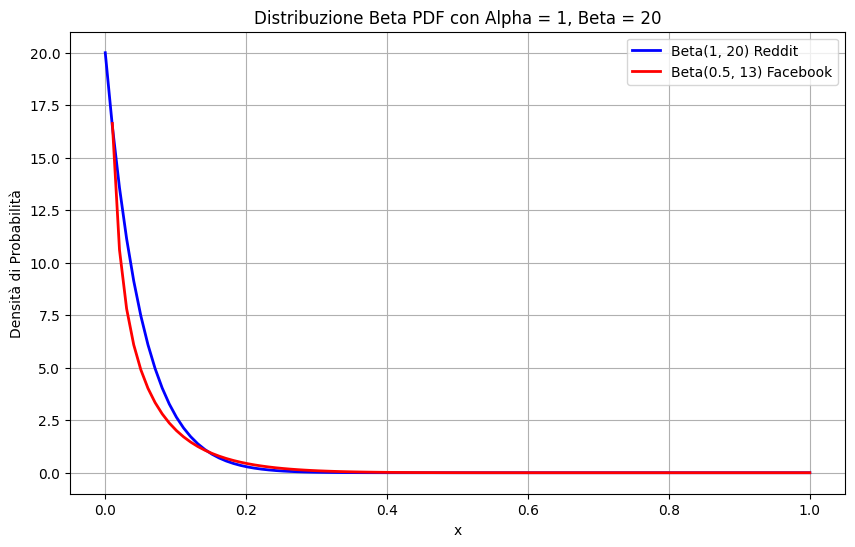

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Parametri della distribuzione beta
alpha =1
beta_param = 20

# Generiamo una griglia di valori x per il plot
x = np.linspace(0, 1, 100)

# Calcoliamo la densità di probabilità (PDF) della distribuzione beta
pdf_beta = beta.pdf(x, alpha, beta_param)
pdf_beta2 = beta.pdf(x, 0.5, 11)

# Plot della distribuzione beta
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_beta, 'b-', lw=2, label=f'Beta({alpha}, {beta_param}) Reddit')
plt.plot(x, pdf_beta2, 'r-', lw=2, label=f'Beta({0.5}, {13}) Facebook')
plt.title(f'Distribuzione Beta PDF con Alpha = {alpha}, Beta = {beta_param}')
plt.xlabel('x')
plt.ylabel('Densità di Probabilità')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# Define social
social = fb

# Define the grid of parameters
parameters = {
    'a': np.arange(0.5, 1.05, 0.2),
    'b': np.arange(10, 14, 1.2),
    'alpha': np.arange(0.8, 1.05, 0.1),
    'lambda_': 4,
    'mu': np.arange(0.1, 0.15, 0.03),
    'sd': np.arange(0.005, 0.03, 0.01),
    'k': np.arange(1, 1.6, 0.3)
}

# Initialize an empty list to store results
results = []
time_intervals = np.arange(0, 1, 0.1)  # Utilizzo di np.arange per intervalli decimali

# Generate all combinations of parameters
param_combinations = list(itertools.product(*parameters.values()))

# Define a function to process each combination
def process_combination(params):
    # Unpack the parameters
    a, b, alpha, lambda_, mu, sd, k = params

    # Simulate synthetic data
    simulated, observed = simulate_data(social, alpha, lambda_, mu, sd, a, b, k, num_threads=10, activate_tqdm=False)

    # Calculate ECDFs
    simulated_ECDF = calculate_ECDF(simulated, time_intervals, activate_tqdm=False)
    simulated_ECDF['Platform'] = 'Simulated'
    observed_ECDF = calculate_ECDF(observed, time_intervals, activate_tqdm=False)
    observed_ECDF['Platform'] = 'Observed'

    # Calculate error
    error = calculate_loss(simulated_ECDF, observed_ECDF)

    # Return results tuple
    return (*params, error)

# Use ProcessPoolExecutor for parallel processing
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_combination, param_combinations), total=len(param_combinations)))

# Convert results list to DataFrame
results_df = pd.DataFrame(results, columns=['a', 'b', 'alpha', 'lambda_', 'mu', 'sd', 'k', 'Error'])

# Optional: Save results to a file
# results_df.to_csv('results.csv', index=False)


  0%|          | 4/1728 [00:26<3:13:16,  6.73s/it]


KeyboardInterrupt: 

In [ ]:
import itertools

# Define social
social=rd

# Define the grid of parameters
parameters = {
    'a': [ 0.1,0.3,0.5,1,2,3],
    'b': [5,10,15, 20, 25,30,35],
    'alpha': [1,0.95,0.9,0.8,0.75],
    'lambda_': [1,4,8,13],
    'mu': [0.002],
    'sd': [0.001],
    'k': [1.0]
}

# Initialize an empty list to store results
results = []

# Generate all combinations of parameters
param_combinations = list(itertools.product(*parameters.values()))

# Loop over each parameter combination
for params in (param_combinations):
    # Unpack the parameters
    a, b, alpha, lambda_, mu, sd, k = params

    # Simulate synthetic data
    simulated, observed = simulate_data(social, alpha, lambda_, mu, sd, a, b, k, num_threads=10)

    # Calculate ECDFs
    simulated_ECDF = calculate_ECDF(simulated, time_intervals)
    simulated_ECDF['Platform'] = 'Simulated'
    observed_ECDF = calculate_ECDF(observed, time_intervals)
    observed_ECDF['Platform'] = 'Observed'

    # Calculate error
    error = calculate_loss(simulated_ECDF, observed_ECDF)

    # Append results tuple to list
    results.append((*params, error))


# Convert results list to DataFrame
results_df = pd.DataFrame(results, columns=['a', 'b', 'alpha', 'lambda_', 'mu', 'sd', 'k', 'Error'])




 50%|█████     | 5/10 [00:00<00:00,  6.61it/s]


KeyboardInterrupt: 

In [ ]:
import itertools

# Define social
social=yt

# Define the grid of parameters
parameters = {
    'a': [ 0.1,0.3,0.5,0.7,1,2],
    'b': [5,7,15, 20,25,30],
    'alpha': [0.7],
    'lambda_': [4],
    'mu': [0.02],
    'sd': [0.001],
    'k': [1.0]
}

# Initialize an empty list to store results
results = []

# Generate all combinations of parameters
param_combinations = list(itertools.product(*parameters.values()))

# Loop over each parameter combination
for params in (param_combinations):
    # Unpack the parameters
    a, b, alpha, lambda_, mu, sd, k = params

    # Simulate synthetic data
    simulated, observed = simulate_data(social, alpha, lambda_, mu, sd, a, b, k, num_threads=5)

    # Calculate ECDFs
    simulated_ECDF = calculate_ECDF(simulated, time_intervals)
    simulated_ECDF['Platform'] = 'Simulated'
    observed_ECDF = calculate_ECDF(observed, time_intervals)
    observed_ECDF['Platform'] = 'Observed'

    # Calculate error
    error = calculate_loss(simulated_ECDF, observed_ECDF)

    # Append results tuple to list
    results.append((*params, error))


# Convert results list to DataFrame
results_df = pd.DataFrame(results, columns=['a', 'b', 'alpha', 'lambda_', 'mu', 'sd', 'k', 'Error'])




,a,b,alpha,lambda_,mu,sd,k,Error
0,0.1,5,0.7,4,0.02,0.001,1.0,65.303787
1,0.1,7,0.7,4,0.02,0.001,1.0,67.229143
2,0.1,15,0.7,4,0.02,0.001,1.0,70.231330
3,0.1,20,0.7,4,0.02,0.001,1.0,70.314775
4,0.1,25,0.7,4,0.02,0.001,1.0,72.431185
5,0.1,30,0.7,4,0.02,0.001,1.0,71.795799
6,0.3,5,0.7,4,0.02,0.001,1.0,47.800080
7,0.3,7,0.7,4,0.02,0.001,1.0,56.481084
8,0.3,15,0.7,4,0.02,0.001,1.0,64.180301
9,0.3,20,0.7,4,0.02,0.001,1.0,67.621112
